# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Предварительный этап - загрузка необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#Настройки pandas
pd.set_option('display.max_columns', 40) #Отображаем все колонки
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Отображаем большие числа без точки

### Откройте файл с данными и изучите общую информацию. 

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
#Посмотрим на первые строки - как выглядит таблица
data.head(5)

total_images  last_price  total_area first_day_exposition  rooms  \
0            20 13000000.00      108.00  2019-03-07T00:00:00      3   
1             7  3350000.00       40.40  2018-12-04T00:00:00      1   
2            10  5196000.00       56.00  2015-08-20T00:00:00      2   
3             0 64900000.00      159.00  2015-07-24T00:00:00      3   
4             2 10000000.00      100.00  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70         16.00        51.00      8          NaN   False   
1             NaN         11.00        18.60      1          NaN   False   
2             NaN          5.00        34.30      4          NaN   False   
3             NaN         14.00          NaN      9          NaN   False   
4            3.03         14.00        32.00     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False         25.00      NaN  Санкт-Петербург          18863.00   
1      False         11.00     2.00   посёлок Шушары          12817.00   
2      False          8.30     0.00  Санкт-Петербург          21741.00   
3      False           NaN     0.00  Санкт-Петербург          28098.00   
4      False         41.00      NaN  Санкт-Петербург          31856.00   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.00              1.00         482.00              2.00   
1             18603.00              0.00            NaN              0.00   
2             13933.00              1.00          90.00              2.00   
3              6800.00              2.00          84.00              3.00   
4              8098.00              2.00         112.00              1.00   

   ponds_nearest  days_exposition  
0         755.00              NaN  
1            NaN            81.00  
2         574.00           558.00  
3         234.00           424.00  
4          48.00           121.00

In [4]:
print(f'Размер таблицы: {data.shape}')
print ()

data.info()

Размер таблицы: (23699, 22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  obj

In [5]:
#Поставим отображение всех колонок при просмотре - размером в 22 колонки мы можем себе это позволить
pd.set_option("display.max_columns", None)

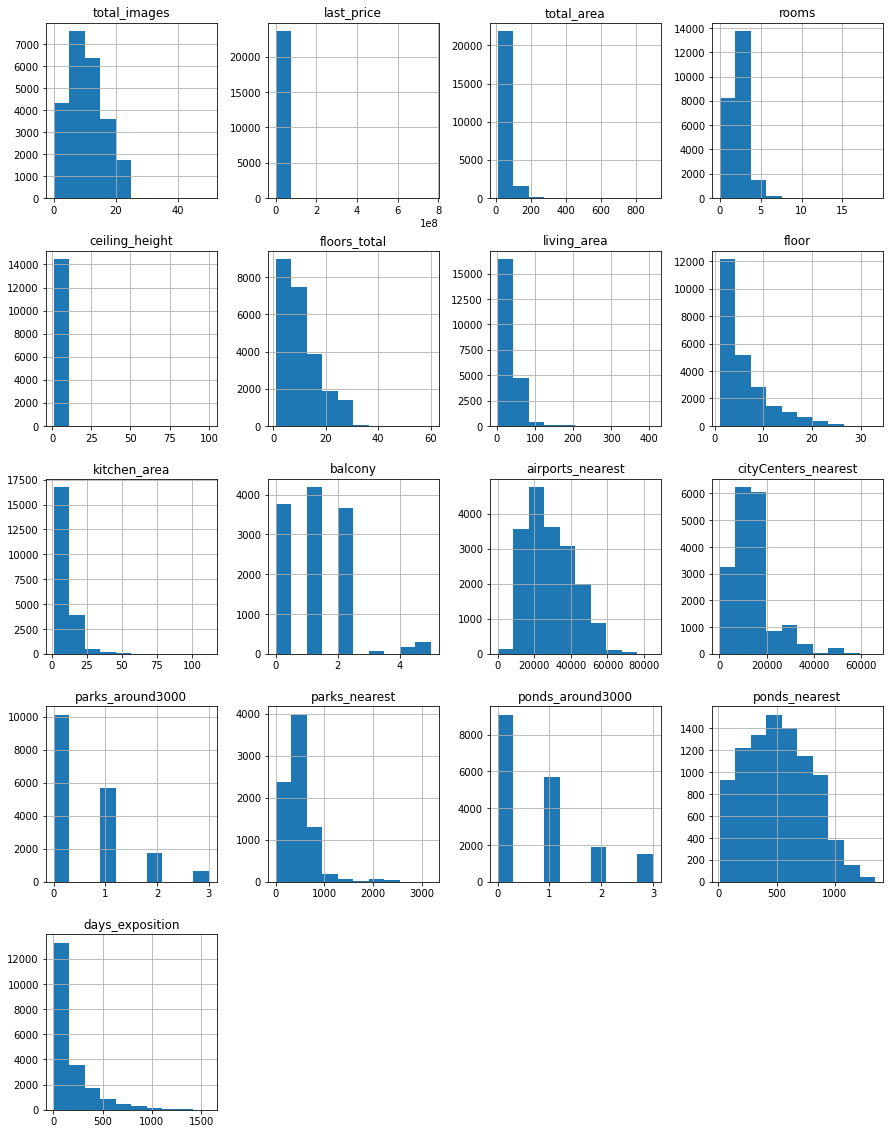

In [6]:
#Построим вводные гистограммы для общего понимания
data.hist(figsize=(15,20));

### Предобработка данных

#### Работа с пропусками

In [7]:
#Для начала посмотрим сколько всего есть пропусков в столбцах таблицы
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
# check
# пропущенные значения бары

# check
def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
        .set_title('Пропуска по столбцам' + "\n", fontsize = 22, color = 'SteelBlue')    
    );    

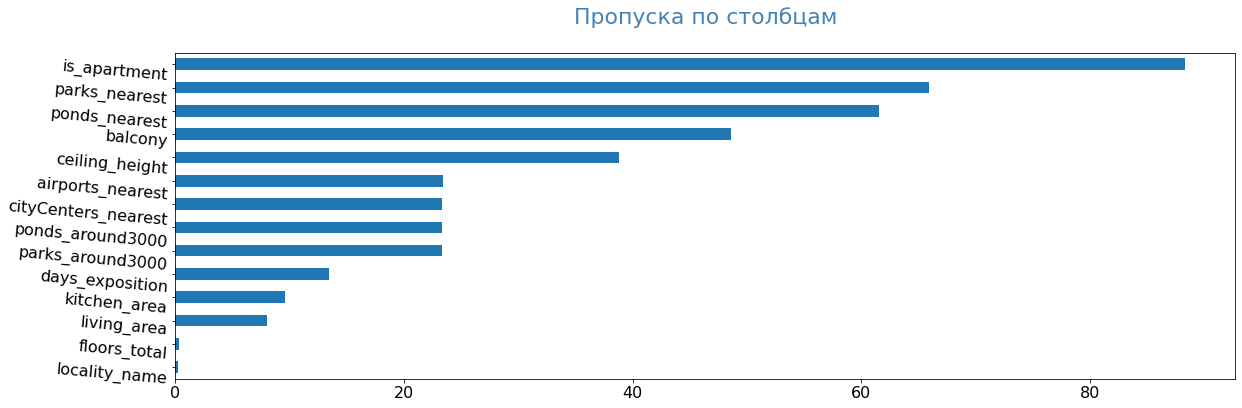

In [9]:
pass_value_barh(data)

В идеале, конечно, стоит уточнить у того, кто предоставил нам данные по поводу природы некоторых пропусков - чтобы не провести анализ на некорректных данных или не заменить то, что заменять не следует

Для начала давайте составим **список столбцов, в которых пропуски можно смело заменять на 0**- по логическим причинам.\
В этот список войдут:
- `balcony`, т.к. можно предположить, что **пропуск означает "0" балконов** (учитывая большое количество пропусков)
- `parks_around3000` и `ponds_around3000`, т.к. учитывая уникальные значения в этих столбцах (число парков/прудов в этом расстоянии), можем предположить, что пропуск скорее означает "0". 


In [10]:
missing_to_zero = ['balcony', 'parks_around3000', 'ponds_around3000']
for x in missing_to_zero:
    data[x] = data[x].fillna(0)

**Далее мы будем смотреть на значения по отдельным столбцам**

##### По столбцу ['is_apartment']

In [11]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Здесь пропуск скорее означает "False" - т.к. изначально должен быть булев тип, и большая часть значений - True|False. Можем заменить на "False" по умолчанию

In [12]:
data['is_apartment'] = data['is_apartment'].fillna(False)

##### По столбцу ['ceiling_height']

In [13]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Здесь пропуски - это скорее всего именно пропуски (забыли написать или данные "потерялись"), **мы не можем заменить их на какое-либо значение, при этом не "соврав" про важную характеристику отдельных квартир.** Однако - если задача - общий анализ, а не выделение отдельных объектов недвижимости, то мы можем заменить на рассчётный показатель (ну или просто на среднее\медиану)

##### По столбцу ['floors_total']

In [14]:
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

In [15]:
#Давайте посмотрим, в каких значейках таблицы бывают пропуски в этом столбце
data[data['floors_total'].isna()].head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
186             12 11640000.00       65.20  2018-10-02T00:00:00      2   
237              4  2438033.00       28.10  2016-11-23T00:00:00      1   
457              4  9788348.00       70.80  2015-08-01T00:00:00      2   
671              4  6051191.00       93.60  2017-04-06T00:00:00      3   
1757             5  3600000.00       39.00  2017-04-22T00:00:00      1   
1930             1  9750000.00       66.77  2016-05-13T00:00:00      2   
2392             7  5395770.00       53.00  2017-06-29T00:00:00      2   
2846             4  2325000.00       27.80  2016-09-21T00:00:00      1   
2952            10  6500000.00       54.30  2019-04-23T00:00:00      1   
3031             9  6400000.00       56.70  2018-03-27T00:00:00      2   

      ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
186              NaN           NaN        30.80      4         False   False   
237              NaN           NaN        20.75      1         False   False   
457              NaN           NaN        38.40     12         False   False   
671              NaN           NaN        47.10      8         False   False   
1757             NaN           NaN          NaN      9         False   False   
1930             NaN           NaN          NaN      4         False   False   
2392             NaN           NaN        29.00     22         False   False   
2846             NaN           NaN        19.40     15         False   False   
2952             NaN           NaN        22.20      6         False   False   
3031             NaN           NaN        32.00     12         False   False   

      open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
186       False         12.00     0.00  Санкт-Петербург          39197.00   
237       False           NaN     0.00  Санкт-Петербург          22041.00   
457       False         10.63     0.00  Санкт-Петербург          37364.00   
671       False         16.80     0.00  Санкт-Петербург          22041.00   
1757      False           NaN     0.00  Санкт-Петербург          22735.00   
1930      False           NaN     0.00  Санкт-Петербург          39886.00   
2392      False          9.00     0.00  Санкт-Петербург          43074.00   
2846      False           NaN     0.00  Санкт-Петербург          22041.00   
2952      False         12.30     0.00  Санкт-Петербург          23606.00   
3031      False         12.00     0.00          Кудрово               NaN   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
186              12373.00              1.00         123.00              0.00   
237              17369.00              0.00            NaN              1.00   
457               8322.00              2.00         309.00              2.00   
671              17369.00              0.00            NaN              1.00   
1757             11618.00              1.00         835.00              1.00   
1930             10660.00              1.00        2276.00              3.00   
2392             10820.00              0.00            NaN              0.00   
2846             17369.00              0.00            NaN              1.00   
2952              3148.00              0.00            NaN              0.00   
3031                  NaN              0.00            NaN              0.00   

      ponds_nearest  days_exposition  
186             NaN            49.00  
237          374.00           251.00  
457          706.00           727.00  
671          374.00           123.00  
1757         652.00            77.00  
1930         244.00            90.00  
2392            NaN            48.00  
2846         374.00           307.00  
2952            NaN              NaN  
3031            NaN           231.00

Видим, что здесь пропуски - **это именно пропуски (этаж не указан).** По умолчанию можно было бы заменить на значение "1" (если бы пропуски означали одноэтажный дом), однако видим, что в столбце "floor" указаны разные значения.

##### По столбцам ['kitchen_area'] и ['living_area']

In [16]:
data['kitchen_area'].unique()

array([ 25.  ,  11.  ,   8.3 ,    nan,  41.  ,   9.1 ,  14.4 ,  18.9 ,
         8.81,   6.5 ,   8.5 ,   6.  ,   9.  ,   5.2 ,   8.  ,   7.6 ,
         5.6 ,  12.  ,   5.7 ,   6.1 ,  19.6 ,  15.  ,   7.  ,   9.2 ,
        11.7 ,  13.4 ,  17.  ,   6.3 ,  11.6 ,   8.8 ,  10.  ,  17.6 ,
         7.5 ,   9.5 ,  50.  ,  15.5 ,  10.7 ,  11.1 ,  20.  ,  11.9 ,
        16.  ,   5.3 ,  11.5 ,   7.2 ,   6.2 ,  10.4 ,   7.1 ,   4.9 ,
         7.3 ,  11.95,  10.2 ,   6.4 ,   5.5 ,  13.  ,   8.4 ,  23.6 ,
        10.8 ,  18.3 ,   5.  ,   8.2 ,  24.  ,  23.8 ,   6.6 ,  26.85,
        15.4 ,   7.8 ,  33.8 ,   5.4 ,  12.72,  12.2 ,  19.  ,  12.4 ,
         7.9 ,  10.3 ,   9.8 ,  17.5 ,  14.7 ,  20.91,  21.3 ,  10.6 ,
        10.9 ,   9.7 ,   7.7 ,  12.5 ,  11.4 ,   8.6 ,  11.24,  14.1 ,
        15.7 ,  13.29,  14.  ,  12.9 ,  12.7 ,  16.5 ,   9.36,  21.5 ,
        35.  ,  10.5 ,   8.7 ,  19.3 ,  21.4 ,  40.  ,  49.2 ,  11.52,
         8.9 ,   9.6 ,  30.  ,  14.2 ,   8.1 ,  10.44,   4.5 ,  16.3 ,
      

In [17]:
data['living_area'].unique()

array([51.  , 18.6 , 34.3 , ..., 31.65, 13.59, 42.55])

In [18]:
#Давайте посмотрим, в каких значейках таблицы бывают пропуски в этом столбце
data[data['kitchen_area'].isna()].head(5)

total_images  last_price  total_area first_day_exposition  rooms  \
3              0 64900000.00      159.00  2015-07-24T00:00:00      3   
30            12  2200000.00       32.80  2018-02-19T00:00:00      1   
37            10  1990000.00       45.80  2017-10-28T00:00:00      2   
44            13  5350000.00       40.00  2018-11-18T00:00:00      1   
59            15  6300000.00       46.50  2017-03-06T00:00:00      1   

    ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
3              NaN         14.00          NaN      9         False   False   
30             NaN          9.00          NaN      2         False   False   
37            2.50          5.00          NaN      1         False   False   
44             NaN         22.00          NaN      3         False   False   
59             NaN         13.00          NaN     13         False   False   

    open_plan  kitchen_area  balcony                        locality_name  \
3       False           NaN     0.00                      Санкт-Петербург   
30      False           NaN     0.00                             Коммунар   
37      False           NaN     0.00  поселок городского типа Красный Бор   
44      False           NaN     1.00                      Санкт-Петербург   
59      False           NaN     0.00                      Санкт-Петербург   

    airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
3           28098.00              6800.00              2.00          84.00   
30               NaN                  NaN              0.00            NaN   
37               NaN                  NaN              0.00            NaN   
44          30471.00             11603.00              1.00         620.00   
59          11125.00             14501.00              0.00            NaN   

    ponds_around3000  ponds_nearest  days_exposition  
3               3.00         234.00           424.00  
30              0.00            NaN            63.00  
37              0.00            NaN           196.00  
44              1.00        1152.00              NaN  
59              0.00            NaN           336.00

In [19]:
data[data['living_area'].isna()].head(5)

total_images  last_price  total_area first_day_exposition  rooms  \
3              0 64900000.00      159.00  2015-07-24T00:00:00      3   
7              5  7915000.00       71.60  2019-04-18T00:00:00      2   
30            12  2200000.00       32.80  2018-02-19T00:00:00      1   
37            10  1990000.00       45.80  2017-10-28T00:00:00      2   
44            13  5350000.00       40.00  2018-11-18T00:00:00      1   

    ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
3              NaN         14.00          NaN      9         False   False   
7              NaN         24.00          NaN     22         False   False   
30             NaN          9.00          NaN      2         False   False   
37            2.50          5.00          NaN      1         False   False   
44             NaN         22.00          NaN      3         False   False   

    open_plan  kitchen_area  balcony                        locality_name  \
3       False           NaN     0.00                      Санкт-Петербург   
7       False         18.90     2.00                      Санкт-Петербург   
30      False           NaN     0.00                             Коммунар   
37      False           NaN     0.00  поселок городского типа Красный Бор   
44      False           NaN     1.00                      Санкт-Петербург   

    airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
3           28098.00              6800.00              2.00          84.00   
7           23982.00             11634.00              0.00            NaN   
30               NaN                  NaN              0.00            NaN   
37               NaN                  NaN              0.00            NaN   
44          30471.00             11603.00              1.00         620.00   

    ponds_around3000  ponds_nearest  days_exposition  
3               3.00         234.00           424.00  
7               0.00            NaN              NaN  
30              0.00            NaN            63.00  
37              0.00            NaN           196.00  
44              1.00        1152.00              NaN

Здесь мы также не можем заменить значения на что-то другое - мы видим, что они присутствуют в недвижимости разного типа, и **скорее всего означают именно то, что человек, заполняя объявление просто не указал эти значения.**

##### По столбцам с ближайшими аэропортами, центрами городов, парками и прудами

In [20]:
data['airports_nearest'].unique()

array([18863., 12817., 21741., ..., 11751., 20151., 24665.])

In [21]:
data[data['parks_nearest'].isna()].head(5)

total_images  last_price  total_area first_day_exposition  rooms  \
1             7  3350000.00       40.40  2018-12-04T00:00:00      1   
5            10  2890000.00       30.40  2018-09-10T00:00:00      1   
6             6  3700000.00       37.30  2017-11-02T00:00:00      1   
7             5  7915000.00       71.60  2019-04-18T00:00:00      2   
8            20  2900000.00       33.16  2018-05-23T00:00:00      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
1             NaN         11.00        18.60      1         False   False   
5             NaN         12.00        14.40      5         False   False   
6             NaN         26.00        10.60      6         False   False   
7             NaN         24.00          NaN     22         False   False   
8             NaN         27.00        15.43     26         False   False   

   open_plan  kitchen_area  balcony              locality_name  \
1      False         11.00     2.00             посёлок Шушары   
5      False          9.10     0.00  городской посёлок Янино-1   
6      False         14.40     1.00          посёлок Парголово   
7      False         18.90     2.00            Санкт-Петербург   
8      False          8.81     0.00             посёлок Мурино   

   airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
1          12817.00             18603.00              0.00            NaN   
5               NaN                  NaN              0.00            NaN   
6          52996.00             19143.00              0.00            NaN   
7          23982.00             11634.00              0.00            NaN   
8               NaN                  NaN              0.00            NaN   

   ponds_around3000  ponds_nearest  days_exposition  
1              0.00            NaN            81.00  
5              0.00            NaN            55.00  
6              0.00            NaN           155.00  
7              0.00            NaN              NaN  
8              0.00            NaN           189.00

In [22]:
print(data['airports_nearest'].max())
print(data['parks_nearest'].max())
print(data['ponds_nearest'].max())
print(data['cityCenters_nearest'].max())

84869.0
3190.0
1344.0
65968.0


В указанных столбцах мы также не можем заменить значение - скорее всего указанные объекты просто очень далеко от аэропортов, центров городов, парков и прудов и программа, заполняющая картографические данные пропустила эти объявления (можно предположить, что в ней стоит какой-то "лимит" - к примеру, расстояние указываем, если оно меньше 100 км (текущие максимальные значения столбцов - в ячейке выше).

В любом случае - **мы не можем заменить здесь на "0", поскольку это будет напротив означать, что эти объекты очень близко.** **Заменить на очень большое значение тоже не вариант** - это окажет влияние на показатели при анализе. 

Ещё один столбец - `locality_name`, который представляет собой место расположения объекта (населённый пункт). Здесь мы также не можем произвести замену без картографических данных об объекте.

Таким образом, мы **оставляем пропуски** в прочих столбцах. При этом важно учитывать, что сохранение точности на данном этапе потребует большей осторожности в дальнейшем - необходимо будет учитывать наличие этих пропусков в данных.

In [23]:
#Оценим итоговый результат
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Типы данных

Вернёмся к проверке типов данных. Давайте ещё раз посмотрим на то, какой тип какие данные имеют и сравним это с тем, что данные должны отражать изначально (исходя из имеющихся у нас сведений)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Первый столбец со странно выглядищим типом данных - `first_day_exposition`, согласно описанию это дата публикации, а значит для удобства анализа **этот столбец нужно перевести в DateTime**

In [25]:
#Давайте посмотрим, в каком формате столбец указан сейчас
print(data['first_day_exposition'].max())
print(data['first_day_exposition'].min())

2019-05-03T00:00:00
2014-11-27T00:00:00


In [26]:
#Переведём его в тип DateTime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")

In [27]:
#Проверим, действительно ли мы поменяли тип данных
data['first_day_exposition'].dtype

dtype('<M8[ns]')

Следующий тип столбцов c проблемой с типом - столбцы, измеряющие число чего-то 
- `floors_total`
- `balcony`
- `days_exposition`
- `parks_around3000`
- `ponds_around3000`

Сейчас это вещественные числа, однако число этажей, балконов, дней, парков и прудов не может быть дробным. Можно предположить, что оно стало таковым из-за пропусков или какой-то ошибки - давайте изменим тип этих данных

In [28]:
float_to_int = ['floors_total', 'balcony', 'days_exposition', 'parks_around3000', 'ponds_around3000']
for x in float_to_int:
    data[x] = data[x].astype(int, errors='ignore')

In [29]:
#Проверим конвертацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Видим, что изменение типов проведено успешно** - столбцы изменены на новый тип (is_apartment был изменён ранее - когда мы убрали из него пропуски), единственный столбец, который не изменён - столбец `total_floors`, который остался типом `float` поскольку в нём сохранились пропуски

#### Работа со столбцом с названиями

Index(...) must be called with a collection of some kind

In [30]:
data.dropna(subset=['locality_name'], inplace=True)

In [31]:
#Для начала посмотрим сколько всего уникальных значений есть у этого столбца
data['locality_name'].nunique()

364

In [32]:
#Давайте выведем их на экран
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видим три момента, которые заметны сразу 
- **Во-первых,** в тексте иногда пишется "ё", а иногда - "е". Это неудобно - давайте избавимся от "ё" в тексте.
- **Во вторых** - в тексте есть посёлки, деревни, посёлки городского типа и городские посёлки. Это может быть полезно при анализе, однако сами названия могут несколько путать нас. Давайте назовём всё типы "посёлков" - "поселками".
- **В третьих** - мы не знаем, как именно высчитывается название населённого пункта (его пишет сам человек, или программа смотрит по карте), но на всякий случай переводим всё в нижний регистр - вдруг кто-то случайно забудет написать название с большой буквы

In [33]:
def fix_locality(text):
    text=str(text).lower().replace("ё", "е")
    text=text.replace("поселок городского типа", "поселок")
    text=text.replace("городской поселок", "поселок")
    text=text.replace("коттеджный поселок", "поселок")
    text=text.replace("поселок при железнодорожной станции", "поселок")
    return text
    
data['locality_proper'] = data['locality_name'].apply(fix_locality)

In [34]:
#Давайте посмотрим, сколько значений удалось "убрать" с помощью такого перекодирования:
print((data['locality_name'].nunique()) - (data['locality_proper'].nunique()))

43


### Нам удалось убрать 43 значения в результате этого простого преобразования!

Давайте посмотрим на получившийся список значений

In [35]:
data['locality_proper'].sort_values().unique()

array(['бокситогорск', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'высоцк', 'гатчина', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'деревня глинка',
       'деревня горбунки', 'деревня гостилицы', 'деревня заклинье',
       'деревня заневка', 'деревня зимитицы', 'деревня извара',
       'деревня иссад', 'деревня калитино', 'деревня кальтино',
       'деревня камышовка', 'деревня каськово', 'деревня келози',
       'деревня кипень', 'деревня кисельня', 'деревня колтуши',
       'деревня коркино', 'деревня котлы', 'деревня кривко',
       'деревня кудрово', 'деревня кузьмолово', 'деревня курковицы',
       'дер

Давайте попробуем более радикальный подход - на данный момент нам не особо интересен анализ типа населённого пункта, поэтому давайте **избавимся от него в целом:**

In [36]:
def remove_locality_type(text):
    locality_types=["поселок ", "село ", "садовое товарищество ", "деревня ", "садоводческое некоммерческое товарищество ", "садовое некоммерческое товарищество ", "станции "]
    for x in locality_types:
        text=text.replace(x, "")
        text=text.replace(x, "")
    return text

data['locality_proper'] = data['locality_proper'].apply(remove_locality_type)

#Давайте посмотрим, сколько значений удалось "убрать" с помощью такого перекодирования:
print((data['locality_name'].nunique()) - (data['locality_proper'].nunique()))

59


Подобным преобразованием нам удалось ещё более сократить список потенциальных дубликатов. Давайте посмотрим на итоговый получившийся список:

In [37]:
data['locality_proper'].sort_values().unique()

array(['агалатово', 'александровская', 'алексеевка', 'аннино', 'аро',
       'барышево', 'батово', 'бегуницы', 'белогорка', 'белоостров',
       'бокситогорск', 'большая вруда', 'большая ижора',
       'большая пустомержа', 'большие колпаны', 'большое рейзино',
       'большой сабск', 'бор', 'борисова грива', 'бугры', 'будогощь',
       'ваганово', 'важины', 'вартемяги', 'вахнова кара', 'вещево',
       'виллози', 'вознесенье', 'возрождение', 'войсковицы', 'войскорово',
       'володарское', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'вырица', 'выскатка', 'высокоключевой', 'высоцк', 'гаврилово',
       'гарболово', 'гатчина', 'гладкое', 'глажево', 'глебычево',
       'глинка', 'гончарово', 'горбунки', 'гостилицы', 'громово',
       'дзержинского', 'дружная горка', 'дружноселье', 'дубровка',
       'елизаветино', 'ефимовский', 'жилгородок', 'жилпоселок', 'житково',
       'заводской', 'заклинье', 'заневка', 'запорожское', 'зеленогорск',
       'зимитицы', 'ивангород', 'извара'

**Примечание** - хотел уже поправить, а реально есть такой населённый пункт оказывается - "хапо-ое")) https://ru.wikipedia.org/wiki/%D0%A5%D0%B0%D0%BF%D0%BE-%D0%9E%D0%B5

На этом **работа со столбцом названий населённых пунктов закончена.** Давайте двигаться дальше...

In [38]:
# check

data['locality_proper'].nunique()

305

In [39]:
# check

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

Внесём обозначенные коррективы:

In [40]:
#Уберём пропуски там, где не указано общее количество этажей в доме

data.dropna(subset=['floors_total'], inplace=True)

In [41]:
#Посмотрим на распределение пропусков по населённым пунктам

data[data['cityCenters_nearest'].isna()]['locality_proper'].value_counts().head(20)

мурино             586
кудрово            470
всеволожск         398
гатчина            307
выборг             237
новое девяткино    143
сертолово          142
кириши             125
бугры              113
сланцы             112
волхов             111
кингисепп          104
тосно              104
никольское          94
коммунар            89
сосновый бор        87
кировск             84
отрадное            80
янино-1             68
приозерск           66
Name: locality_proper, dtype: int64

In [42]:
#Большие цифры у первых значений. А давайте посмотрим на топов в целом...
data['locality_proper'].value_counts().head(20)

санкт-петербург    15651
мурино               586
кудрово              470
шушары               439
всеволожск           398
пушкин               369
колпино              338
парголово            327
гатчина              307
выборг               237
петергоф             201
сестрорецк           183
красное село         176
новое девяткино      143
сертолово            142
ломоносов            133
кириши               125
бугры                113
сланцы               112
волхов               111
Name: locality_proper, dtype: int64

В целом, мы видим, что пропуски локализованы в умеренно не-растянутых населённых пунктах (всего - в 55 пунктах есть пропуски), т.е. теоретически мы можем заменить их на медианное значение расстояние по населённому пункту, при этом в ряде пунктов число пропусков составляет 100% (в том же Мурино)

Можно предположить, что люди не знали, до какого центра расстояние указывать - до центра мурино, или до центра Санкт-Петербурга. 

**Учитывая, что наше задание в дальнейшем предполагает анализ стоимости километра именно в Санкт-Петербурге - то пропуски здесь не повлияют на это значение.** Но чисто теоретически - можно подобрать это расстояние исходя из открытых и картографических данных.

Если считаешь, что есть смысл это сделать сейчас - можно, но пока что я пропущу этот шаг))

#### Работа с выбросами

Для начала - давайте ещё раз построим гистограммы для понимания общей картины - с чем нам предстоит работать

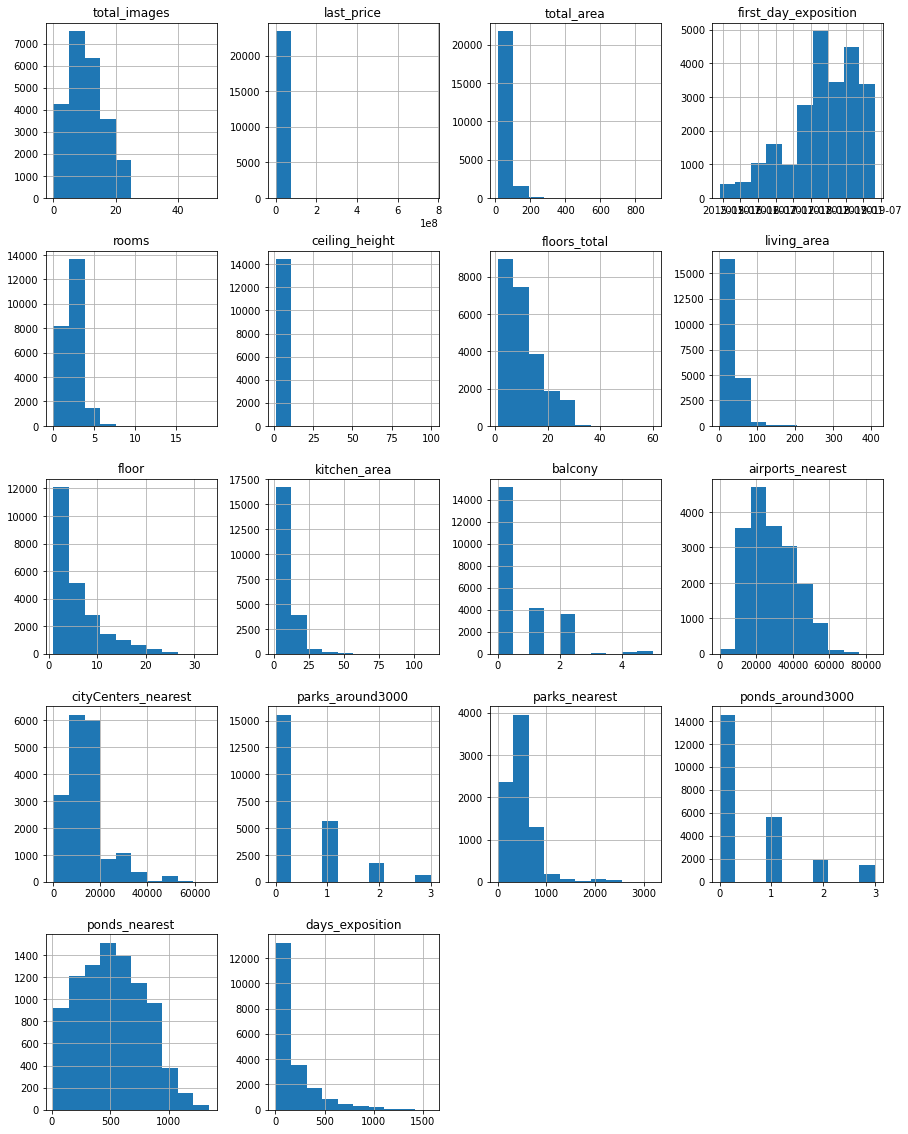

In [43]:
#Построим вводные гистограммы для общего понимания
data.hist(figsize=(15,20));

Пройдёмся **по каждому столбцу, вызывающему вопросы отдельно** и построим график для понимания ситуации:

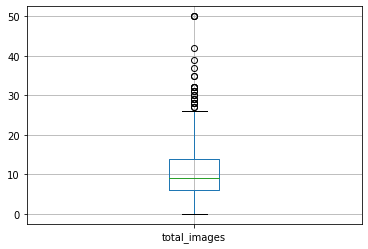

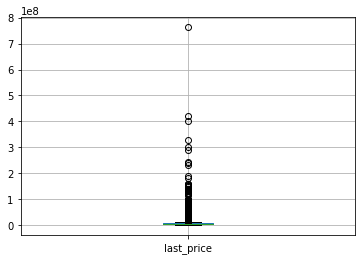

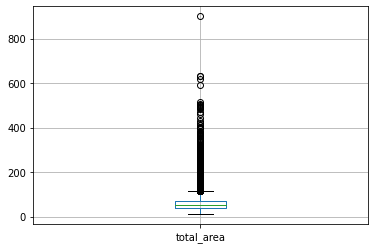

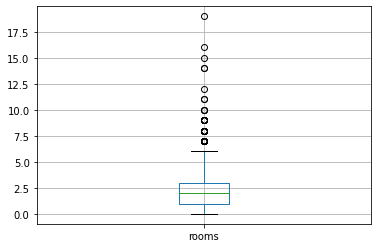

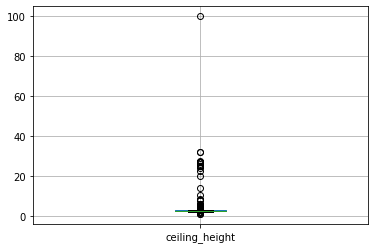

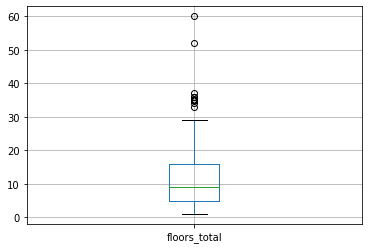

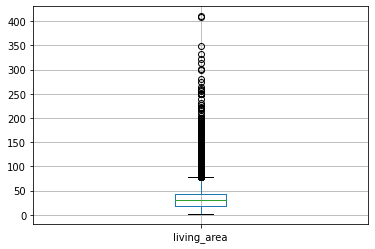

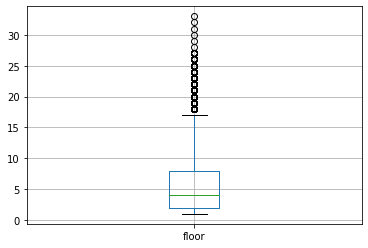

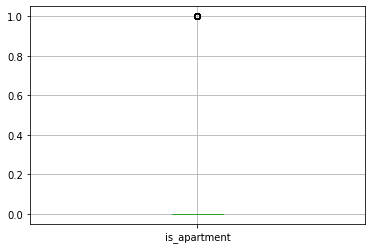

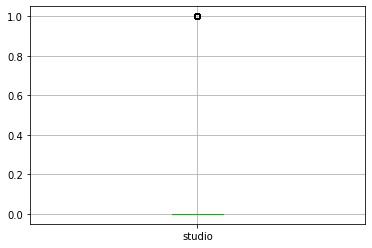

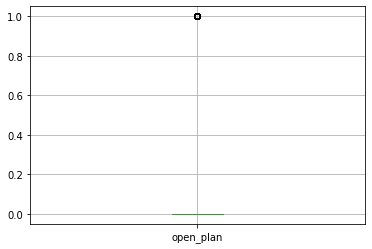

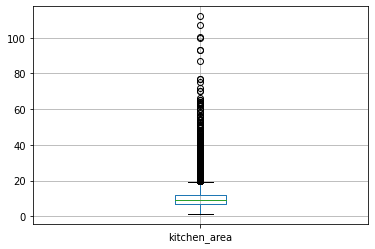

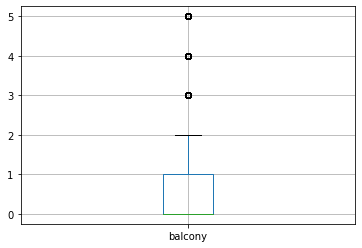

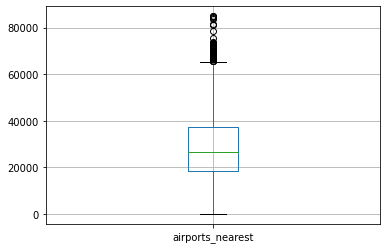

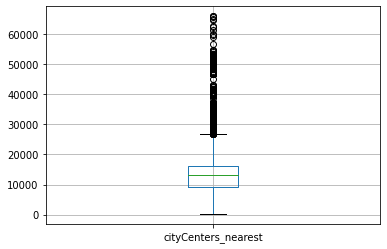

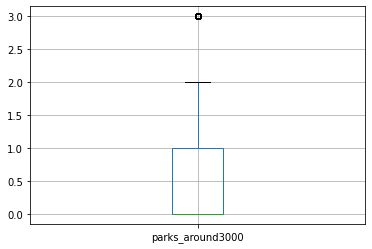

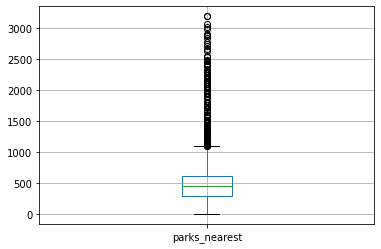

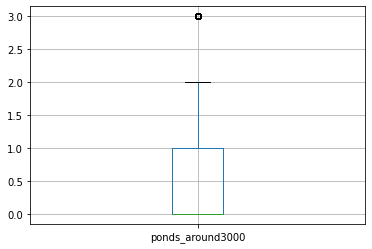

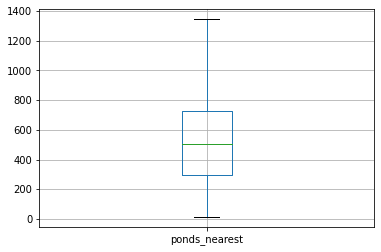

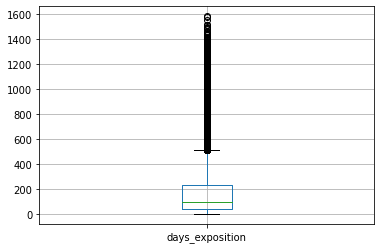

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

data_boxplots = data.select_dtypes(exclude=['object', 'datetime'])

for column in data_boxplots:
    plt.figure()
    data_boxplots.boxplot([column])

Обозначим столбцы, в которых наблюдаем потенциальные выбросы для дальнейшего анализа:
- `last_price`
- `total_area`
- `rooms`
- `ceiling_height`
- `floors_total`
- `living_area`
- `floor`
- `kitchen_area`
- `days_exposition`

**Пройдёмся по порядку:**

In [45]:
potential_outliers_columns = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'days_exposition']

for column in potential_outliers_columns:
    print(column)
    print(data[column].describe().apply(lambda x: format (x, 'f')))
    print()
    print()

last_price
count        23565.000000
mean       6540058.260004
std       10910934.721514
min          12190.000000
25%        3400000.000000
50%        4646000.000000
75%        6790000.000000
max      763000000.000000
Name: last_price, dtype: object


total_area
count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: object


rooms
count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: object


ceiling_height
count    14481.000000
mean         2.771283
std          1.261983
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: object


floors_total
count    23565.000000
mean        10.675875
std          6.594823
min    

**Первый столбец со "странными" значениями - "ceiling_height"** (высота потолка 100 метров?)

In [46]:
data['ceiling_height'].sort_values(ascending=False).head(30)

22869   100.00
3148     32.00
22336    32.00
21377    27.50
20478    27.00
22938    27.00
21824    27.00
4876     27.00
10773    27.00
17857    27.00
5246     27.00
5807     27.00
5669     26.00
11285    25.00
9379     25.00
4643     25.00
14382    25.00
18545    25.00
6246     25.00
355      25.00
5076     24.00
20507    22.60
17496    20.00
15061    14.00
22309    10.30
5863      8.30
15743     8.00
17442     8.00
3474      8.00
20264     6.00
Name: ceiling_height, dtype: float64

Небольшое кабинетное исследование говорит нам о том, что в самых "элитных" квартирах высота потолка равняется примерно 10 метрам (это прямо особняки), а минимальное значение высоты - 2.4 метра. При корректировке будем отталкиваться от этого:

In [47]:
#Если значение больше 24, то скорее всего это ошибка при записи и нужно разделить на 10, в ином случае - оставить прежнее значение
def height_change(x):
    if x >= 24:
        return x / 10
    else:
        return x
    
data['ceiling_height'] = data['ceiling_height'].apply(height_change)

In [48]:
#Проверим результат
data['ceiling_height'].sort_values(ascending=False).head(10)

20507   22.60
17496   20.00
15061   14.00
22309   10.30
22869   10.00
5863     8.30
17442    8.00
3474     8.00
15743    8.00
20264    6.00
Name: ceiling_height, dtype: float64

**Второй столбец со "странными" значениями - "floors_total"** (60 этажей - такое бывает, но редко). Посмотрим...

In [49]:
data.sort_values(by='floors_total', ascending=False).head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
2253             12  3800000.00       45.50           2018-06-28      2   
16731             9  3978000.00       40.00           2018-09-24      1   
16934             5  4100000.00       40.00           2017-10-17      1   
5807             17  8150000.00       80.00           2019-01-09      2   
11079            16  9200000.00       75.00           2019-02-22      2   
397              15  5990000.00       54.00           2018-03-22      2   
13975            19  6990000.00       65.00           2018-10-06      2   
2966              9  4300000.00       37.00           2017-08-08      1   
9186              7  6500000.00       49.10           2019-04-12      1   
1917             13 10150000.00       74.00           2017-11-17      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
2253             2.88         60.00        27.40      4         False   False   
16731            2.65         52.00        10.50     18         False   False   
16934            1.75         37.00        17.40      5         False   False   
5807             2.70         36.00        41.00     13         False   False   
11079            2.70         36.00        40.00     29         False   False   
397               NaN         36.00        21.40     28         False   False   
13975             NaN         35.00        32.10     23         False   False   
2966              NaN         35.00        14.00     15         False   False   
9186             2.50         35.00        31.00      3         False   False   
1917             2.80         35.00        34.40     30         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
2253       False          7.40        0        Кронштадт          67763.00   
16731      False         14.00        0  Санкт-Петербург          20728.00   
16934      False          8.34        0  Санкт-Петербург          18732.00   
5807       False         12.00        5  Санкт-Петербург          18732.00   
11079      False         12.00        2  Санкт-Петербург          18732.00   
397        False         18.70        1  Санкт-Петербург          18732.00   
13975      False          8.90        0  Санкт-Петербург          18732.00   
2966       False         10.40        0  Санкт-Петербург          18732.00   
9186       False          7.00        0  Санкт-Петербург          18732.00   
1917       False         13.00        0  Санкт-Петербург          18732.00   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
2253              49488.00                 2         342.00                 3   
16731             12978.00                 1         793.00                 0   
16934             20444.00                 0            NaN                 3   
5807              20444.00                 0            NaN                 3   
11079             20444.00                 0            NaN                 3   
397               20444.00                 0            NaN                 3   
13975             20444.00                 0            NaN                 3   
2966              20444.00                 0            NaN                 3   
9186              20444.00                 0            NaN                 3   
1917              20444.00                 0            NaN                 3   

       ponds_nearest  days_exposition  locality_proper  
2253          614.00           166.00        кронштадт  
16731            NaN            45.00  санкт-петербург  
16934          80.00            71.00  санкт-петербург  
5807           80.00            38.00  санкт-петербург  
11079          80.00              NaN  санкт-петербург  
397            80.00            11.00  санкт-петербург  
13975          80.00            89.00  санкт-петербург  
2966           80.00            50.00  санкт-петербург  
9186           80.00     

В Кронштадте нет 60-этажных домов*, а кратное 10 значение указывает на то, что это скорее всего опечатка. Поэтому разделим на 10 (учитывая, что недвижимость на 6 этаже - это звучит вероятно)

*https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%B8%D1%85_%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B9_%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0

In [50]:
data.loc[2253, 'floors_total'] = 6

**Ещё 4 столбца со "странными" значениями - "living_area"** (409 квадратных метров жилой площади - неплохо!), **"kitchen_area"** (111 метров кухни), **"total_area"** и **"rooms"**

In [51]:
data.sort_values(by='living_area', ascending=False).head(5)

total_images   last_price  total_area first_day_exposition  rooms  \
19540             8 420000000.00      900.00           2017-12-06     12   
5358             20  65000000.00      590.00           2019-02-14     15   
12401            20  91500000.00      495.00           2017-06-19      7   
4237              1  50000000.00      517.00           2017-10-14      7   
12859            20 140000000.00      631.20           2019-04-09      7   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
19540            2.80         25.00       409.70     25         False   False   
5358             3.50          6.00       409.00      3         False   False   
12401            4.65          7.00       347.50      7         False   False   
4237              NaN          4.00       332.00      3         False   False   
12859            3.90          4.00       322.30      4         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
19540      False        112.00        0  Санкт-Петербург          30706.00   
5358       False        100.00        0  Санкт-Петербург          24447.00   
12401      False         25.00        0  Санкт-Петербург               NaN   
4237       False         22.00        0  Санкт-Петербург          22835.00   
12859      False         19.50        1  Санкт-Петербург          25707.00   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
19540              7877.00                 0            NaN                 2   
5358               4666.00                 1         767.00                 0   
12401              5735.00                 2         110.00                 0   
4237               1847.00                 2         477.00                 2   
12859              4972.00                 0            NaN                 2   

       ponds_nearest  days_exposition  locality_proper  
19540         318.00           106.00  санкт-петербург  
5358             NaN            14.00  санкт-петербург  
12401            NaN            14.00  санкт-петербург  
4237          540.00              NaN  санкт-петербург  
12859         210.00              NaN  санкт-петербург

In [52]:
data.sort_values(by='kitchen_area', ascending=False).head(5)

total_images   last_price  total_area first_day_exposition  rooms  \
19540             8 420000000.00      900.00           2017-12-06     12   
20215             2  85000000.00      249.70           2018-02-01      3   
2489              9  12500000.00      255.00           2017-04-21      3   
5358             20  65000000.00      590.00           2019-02-14     15   
16239             5  82400000.00      181.10           2017-05-24      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
19540            2.80         25.00       409.70     25         False   False   
20215             NaN         10.00        72.00      9         False   False   
2489              NaN          2.00       153.90      2         False   False   
5358             3.50          6.00       409.00      3         False   False   
16239            3.90          9.00        58.20      4         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
19540      False        112.00        0  Санкт-Петербург          30706.00   
20215      False        107.00        4  Санкт-Петербург          31532.00   
2489       False        100.70        0  Санкт-Петербург          29544.00   
5358       False        100.00        0  Санкт-Петербург          24447.00   
16239      False         93.20        0  Санкт-Петербург          25525.00   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
19540              7877.00                 0            NaN                 2   
20215              4624.00                 1        2218.00                 2   
2489               6916.00                 0            NaN                 3   
5358               4666.00                 1         767.00                 0   
16239              5845.00                 2         116.00                 0   

       ponds_nearest  days_exposition  locality_proper  
19540         318.00           106.00  санкт-петербург  
20215          99.00            26.00  санкт-петербург  
2489          198.00           102.00  санкт-петербург  
5358             NaN            14.00  санкт-петербург  
16239            NaN           501.00  санкт-петербург

In [53]:
data.sort_values(by='total_area', ascending=False).head(5)

total_images   last_price  total_area first_day_exposition  rooms  \
19540             8 420000000.00      900.00           2017-12-06     12   
12859            20 140000000.00      631.20           2019-04-09      7   
3117             19 140000000.00      631.00           2019-03-30      7   
15651            20 300000000.00      618.00           2017-12-18      7   
5358             20  65000000.00      590.00           2019-02-14     15   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
19540            2.80         25.00       409.70     25         False   False   
12859            3.90          4.00       322.30      4         False   False   
3117              NaN          5.00          NaN      5         False   False   
15651            3.40          7.00       258.00      5         False   False   
5358             3.50          6.00       409.00      3         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
19540      False        112.00        0  Санкт-Петербург          30706.00   
12859      False         19.50        1  Санкт-Петербург          25707.00   
3117       False         60.00        0  Санкт-Петербург          25707.00   
15651      False         70.00        0  Санкт-Петербург          32440.00   
5358       False        100.00        0  Санкт-Петербург          24447.00   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
19540              7877.00                 0            NaN                 2   
12859              4972.00                 0            NaN                 2   
3117               4972.00                 0            NaN                 2   
15651              5297.00                 0            NaN                 2   
5358               4666.00                 1         767.00                 0   

       ponds_nearest  days_exposition  locality_proper  
19540         318.00           106.00  санкт-петербург  
12859         210.00              NaN  санкт-петербург  
3117          210.00              NaN  санкт-петербург  
15651         198.00           111.00  санкт-петербург  
5358             NaN            14.00  санкт-петербург

Всё в порядке. Недвижимость конечно роскошная, спору нет, но ошибок тут нет (и жилплощадь и кухонная меньше total_area), и показатели высокие у действительно больших и дорогих квартир

А вот с показателем `rooms` несколько интереснее - у больших квартир много комнат, здесь всё в порядке, однако много квартир, где число комнат равняется нулю

In [54]:
data.sort_values(by='rooms', ascending=False).tail(5)

total_images  last_price  total_area first_day_exposition  rooms  \
10416             8  3700000.00       29.10           2018-08-28      0   
6612             18  3590000.00       26.80           2017-11-10      0   
2563              4  3170000.00       28.40           2018-07-26      0   
12412             0  3300000.00       27.00           2017-08-15      0   
10182            14  2250000.00       24.75           2018-10-02      0   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
10416            2.60         14.00        20.50      2         False    True   
6612              NaN         24.00        19.00     20         False   False   
2563              NaN         23.00        20.46      2         False    True   
12412             NaN         25.00        25.00     22         False   False   
10182             NaN         19.00        17.20      6         False    True   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
10416      False           NaN        0  Санкт-Петербург          42068.00   
6612        True           NaN        0  Санкт-Петербург          11022.00   
2563       False           NaN        2  Санкт-Петербург          21460.00   
12412       True           NaN        0  Санкт-Петербург          12199.00   
10182      False           NaN        2   посёлок Мурино               NaN   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
10416             10240.00                 1         637.00                 0   
6612              12679.00                 0            NaN                 0   
2563              16788.00                 0            NaN                 1   
12412             12111.00                 0            NaN                 1   
10182                  NaN                 0            NaN                 0   

       ponds_nearest  days_exposition  locality_proper  
10416            NaN            37.00  санкт-петербург  
6612             NaN            15.00  санкт-петербург  
2563          170.00            28.00  санкт-петербург  
12412         337.00           161.00  санкт-петербург  
10182            NaN            13.00           мурино

In [55]:
print(data.query('rooms == 0 and studio == True')['rooms'].count())
print(data.query('rooms > 1 and studio == True')['rooms'].count())

135
0


Есть 138 объектов, которые обозначены как "студия", но имеют 0 указанных комнат. Это некорректно - студия это по определению одна комната. Нужно исправить. 

P.S: К счастью, двухкомнатных и больше студий в базе данных нет

Также есть объекты с открытой планировкой, которые имеют 0 комнат, что в целом соответствует действительности, но на деле у них скорее "нет" комнат, как таковых, при этом многие из них достаточно дорогие (сильно повлияют на среднюю цену 1-комнатных квартир) - стоит заменить их на пропуски. Это, конечно, вернёт пропуски и снова заменит тип переменной на `float`, однако будет лучше отражать действительность

In [56]:
data.loc[data.studio == True, 'rooms'] = 1
data.loc[data['open_plan'] == True, 'rooms'] = None

In [57]:
#Проверяем результат нашей манипуляции
data.rooms.max()

19.0

In [58]:
#Сколько осталось "бескомнатных" квартир...
data.query('rooms == 0')['rooms'].count()

0

**Ещё одна выпадающая цифра - "floor",** много больших цифр. Однако, при проверке видим, что всё в порядке - и правда, просто многоэтажные дома. При этом 0 нет - здесь всё ок.

In [59]:
data.sort_values(by='floor', ascending=False).head(5)

total_images  last_price  total_area first_day_exposition  rooms  \
18218             4  9900000.00      101.00           2018-09-27   3.00   
11575             9  9900000.00      101.00           2016-04-28   3.00   
18629            20  5700000.00       54.00           2017-12-08   1.00   
1917             13 10150000.00       74.00           2017-11-17   2.00   
11079            16  9200000.00       75.00           2019-02-22   2.00   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
18218             NaN         35.00        53.40     33         False   False   
11575             NaN         33.00        53.00     32         False   False   
18629             NaN         35.00        21.00     31         False   False   
1917             2.80         35.00        34.40     30         False   False   
11079            2.70         36.00        40.00     29         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
18218      False         13.70        2  Санкт-Петербург          18737.00   
11575      False         21.00        0  Санкт-Петербург          18732.00   
18629      False         18.00        0  Санкт-Петербург          18732.00   
1917       False         13.00        0  Санкт-Петербург          18732.00   
11079      False         12.00        2  Санкт-Петербург          18732.00   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
18218             20450.00                 0            NaN                 3   
11575             20444.00                 0            NaN                 3   
18629             20444.00                 0            NaN                 3   
1917              20444.00                 0            NaN                 3   
11079             20444.00                 0            NaN                 3   

       ponds_nearest  days_exposition  locality_proper  
18218          72.00             7.00  санкт-петербург  
11575          80.00            53.00  санкт-петербург  
18629          80.00           128.00  санкт-петербург  
1917           80.00              NaN  санкт-петербург  
11079          80.00              NaN  санкт-петербург

**Последний столбец со странными значениями - "days_exposition"**. Посмотрим на находящуюся 1500+ дней квартиру...

In [60]:
data.sort_values(by='days_exposition', ascending=False).head(5)

total_images  last_price  total_area first_day_exposition  rooms  \
18843            11  3500000.00       48.20           2014-12-15   2.00   
1109              1 34878556.00       95.80           2014-12-09   2.00   
9553             11 10600000.00       80.00           2014-12-09   3.00   
1885              2 13300000.00       79.60           2014-12-09   2.00   
20969            18 13300000.00      133.00           2015-02-11   4.00   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
18843            2.50          5.00        27.40      2         False   False   
1109              NaN          6.00        58.30      5          True   False   
9553             2.85         17.00        44.00      9         False   False   
1885             3.00          8.00        42.70      7         False   False   
20969            3.00          5.00        58.00      2         False   False   

       open_plan  kitchen_area  balcony            locality_name  \
18843      False          7.70        3  деревня Новое Девяткино   
1109       False         20.00        1          Санкт-Петербург   
9553       False         15.00        0          Санкт-Петербург   
1885       False         18.00        0          Санкт-Петербург   
20969      False         45.00        0          Санкт-Петербург   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
18843               NaN                  NaN                 0            NaN   
1109           21860.00               318.00                 2         160.00   
9553           17101.00             17110.00                 0            NaN   
1885           39393.00             11096.00                 1         537.00   
20969          24653.00              5032.00                 0            NaN   

       ponds_around3000  ponds_nearest  days_exposition  locality_proper  
18843                 0            NaN          1580.00  новое девяткино  
1109                  3         569.00          1572.00  санкт-петербург  
9553                  0            NaN          1553.00  санкт-петербург  
1885                  0            NaN          1513.00  санкт-петербург  
20969                 1         534.00          1512.00  санкт-петербург

**Выглядит нормально.** Но на этом этапе я бы уточнил у того, кто предоставил мне данные момент выгрузки - можно попробовать посчитать разницу между датой публикации и текущим днём и сверить показатели. Т.к. такой информации у меня нет, а данные в целом выглядят нормально - то оставляем. 

Но давайте проверим данные "с хвоста" - как обстоит ситуация с 0?

In [61]:
data.sort_values(by='days_exposition', ascending=True).head(5)

total_images  last_price  total_area first_day_exposition  rooms  \
1632             19  4000000.00       49.90           2019-05-01   2.00   
16053             4  4070000.00       45.10           2019-04-30   2.00   
13061            20  6100000.00       51.40           2019-04-29   2.00   
16212             0  7806000.00       25.00           2019-04-30   1.00   
5696              9  3480000.00       43.90           2018-01-20   2.00   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
1632             2.50          9.00        25.00      1         False   False   
16053             NaN          5.00        22.70      3         False   False   
13061            3.00          5.00        31.70      4         False   False   
16212            3.00          5.00          NaN      5         False   False   
5696              NaN          5.00        27.90      4         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
1632       False         10.00        0  Санкт-Петербург          13567.00   
16053      False          6.60        0  Санкт-Петербург          40859.00   
13061      False          6.90        1  Санкт-Петербург          10776.00   
16212      False           NaN        0  Санкт-Петербург          36525.00   
5696       False          5.00        0  Санкт-Петербург           7056.00   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
1632              14384.00                 1          20.00                 1   
16053             11668.00                 2         485.00                 0   
13061              9389.00                 0            NaN                 0   
16212             10302.00                 0            NaN                 0   
5696              17233.00                 1         658.00                 0   

       ponds_nearest  days_exposition  locality_proper  
1632          681.00             1.00  санкт-петербург  
16053            NaN             2.00  санкт-петербург  
13061            NaN             2.00  санкт-петербург  
16212            NaN             2.00  санкт-петербург  
5696             NaN             3.00  санкт-петербург

В целом всё в порядке, просто видим набор недвижимости, которую сняли/выкупили в первый же день. Странно, но такое случается :)



P.S: Теоретически, можно было бы рассчитать, какой "сегодня" день при работе с историческим датасетом - просто посмотреть на объекты, опубликованные "вчера"

Таким образом, **результат анализа выбросов:**

- `ceiling_height` - скорее всего были опечатки, поправили в соответствии с предполагаемыми значениями.
- `floors_total` - скорее всего была одна опечатка (в Кронштадте нет 60-этажных домов), поправили.
- `last_price` - цены действительно заоблачные, однако в целом не являются выбросом - квартиры такой стоимости действительно существуют, и их довольно много (как показал быстрый поиск на релевантных сайтах с недвижимостью (включая Яндекс ;)
- `living_area` - здесь всё в порядке, хотя есть и роскошная недвижимость :)
- `kitchen_area` - здесь всё в порядке, хотя есть и роскошная недвижимость :)
- `total_area` - здесь всё в порядке, хотя есть и роскошная недвижимость :)
- `days_exposition` - всё в порядке, просто пара очень долго продававшихся домов.
- `rooms` - был ряд студий, которые имели 0 комнат, этот показатель мы исправили на 1. В помещениях с открытой планировкой - заменили показатель на пропуск
- `floor` - здесь всё в порядке, просто многоэтажные дома


Следующая задача - **отобрать выбросы, которые в целом являются корректными записями, однако могут повлиять на результаты нашего анализа.**

In [62]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'locality_proper'],
      dtype='object')

In [63]:
#Отберём только необходимые нам переменные
columns_for_extraction = ['last_price',
                          'total_area',
                          'living_area',
                          'kitchen_area',
                          'airports_nearest',
                          'cityCenters_nearest',
                          'parks_nearest',
                          'ponds_nearest',
                          'days_exposition']
                          
#Искажения в этих переменных могут повлиять на анализ, при этом будут сильно выделяться из общего списка. 
                          
data_numerical = data[columns_for_extraction]
data_numerical.shape

(23565, 9)

Если взять стандартные 1.5 размаха, то будет удалённо слишком большое число наблюдений (около трети всей базы). 

Вместо этого **сфокусируемся на более явных выбросах** - отбросим в указанных колонках наблюдения, которые больше/меньше чем на **3 межквартильных размаха.**

Также делаем поправку на пропуски, которые мы сохранили в данных - на их основании нельзя рассчитывать квантили и размахи, поэтому их мы пропускаем.

In [64]:
for column in data_numerical.columns:
    Q1 = data_numerical[column].quantile(0.25)
    Q3 = data_numerical[column].quantile(0.75)
    IQR = Q3 - Q1

    curr_shape = data_numerical.shape[0]
    data_numerical = data_numerical[(data_numerical[column].isna() |  #Не трогаем строчки с пропусками
                                     ~((data_numerical[column] < (Q1 - 3 * IQR)) | 
                                       (data_numerical[column] > (Q3 + 3 * IQR))))]
    print(f'После очистки по столбцу {column} c IQR равным {IQR} было удалено {curr_shape - data_numerical.shape[0]} наблюдений')
print(f'Итогое количество наблюдений = {data_numerical.shape[0]}')

После очистки по столбцу last_price c IQR равным 3390000.0 было удалено 967 наблюдений
После очистки по столбцу total_area c IQR равным 26.599999999999994 было удалено 148 наблюдений
После очистки по столбцу living_area c IQR равным 22.2 было удалено 3 наблюдений
После очистки по столбцу kitchen_area c IQR равным 4.300000000000001 было удалено 305 наблюдений
После очистки по столбцу airports_nearest c IQR равным 19263.0 было удалено 0 наблюдений
После очистки по столбцу cityCenters_nearest c IQR равным 6314.5 было удалено 357 наблюдений
После очистки по столбцу parks_nearest c IQR равным 322.0 было удалено 118 наблюдений
После очистки по столбцу ponds_nearest c IQR равным 430.0 было удалено 0 наблюдений
После очистки по столбцу days_exposition c IQR равным 176.0 было удалено 598 наблюдений
Итогое количество наблюдений = 21069


Посмотрим на гистограммы этих столбцов рядом с друг-другом, чтобы проверить, как изменилось распределение:

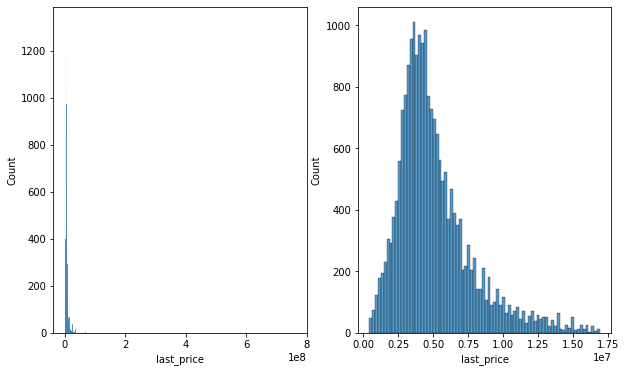

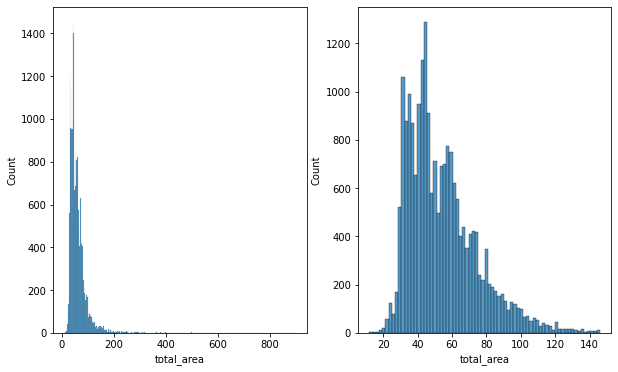

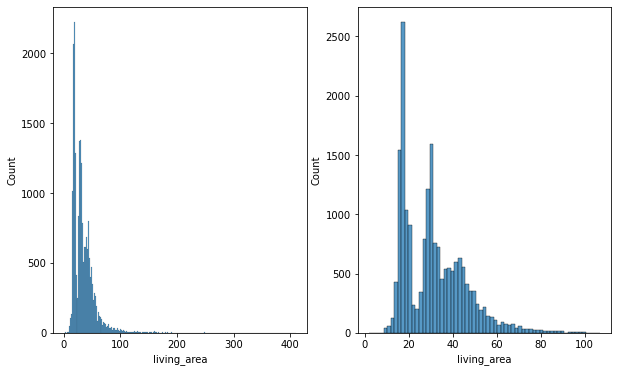

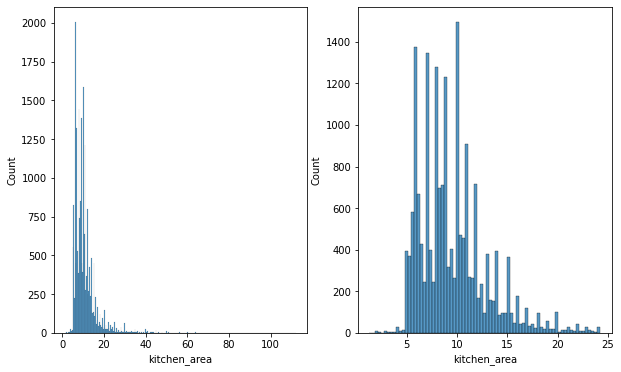

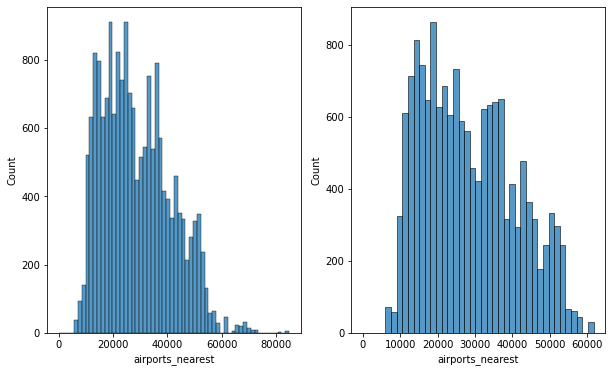

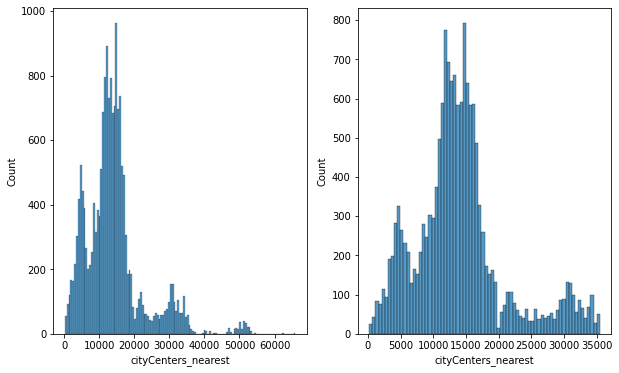

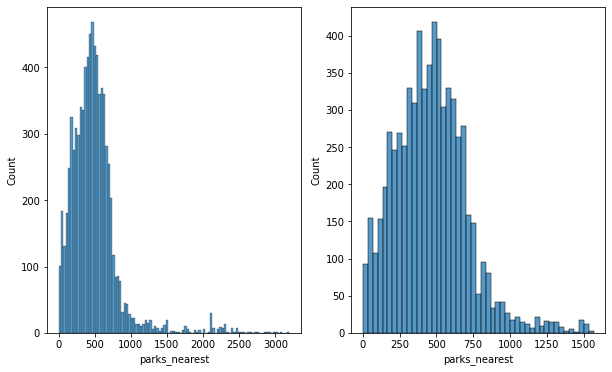

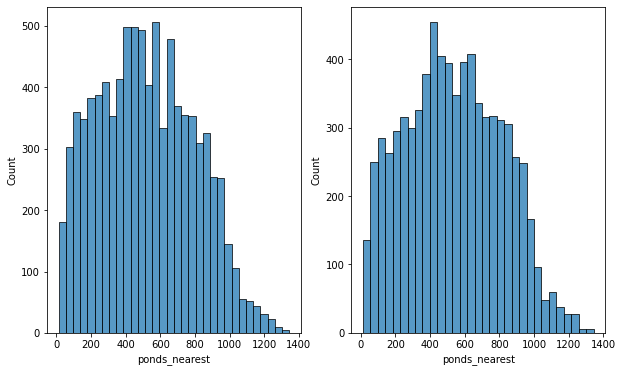

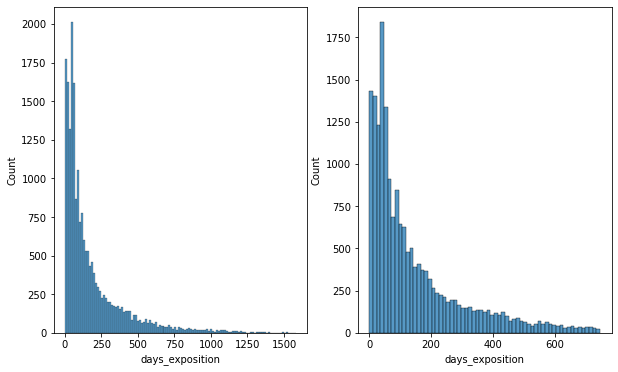

In [65]:
import seaborn as sns
#Знаю, что в пандас есть "встроенные" графики, но мне кажется, что seaborn красивее и выразительнее. 
#Но требует чуть большей подготовки)

for column in data_numerical.columns:
    fig, ax = plt.subplots(1, 2, figsize=(10,6))
    sns.histplot(data=data, x=column, ax=ax[0])
    sns.histplot(data=data_numerical, x=column, ax=ax[1])

Теперь данные выглядят "здоровее". **Можем объединить датасеты** (чтобы сохранить правки, которые мы делали в датасете data_numerical):

P.S: На своём компьютере я бы вполне вероятно делал чуть по другому - если бы работал с большим числом данных, то правил бы сразу в оригинальном, т.к. оперативы бы не хватило на реально большом наборе, но дай бог здоровья яндексу - памяти хватает на то, чтобы в RAM держать сразу два датасета)

Ну и да, эти маленькие.)

Давайте объединим датафреймы:

In [66]:
data_fixed = data_numerical.join(data, rsuffix='DELETE')

#Проверим, всё ли в порядке
print(data_fixed.shape[0])
data_fixed.head(1)

21069


last_price  total_area  living_area  kitchen_area  airports_nearest  \
1  3350000.00       40.40        18.60         11.00          12817.00   

   cityCenters_nearest  parks_nearest  ponds_nearest  days_exposition  \
1             18603.00            NaN            NaN            81.00   

   total_images  last_priceDELETE  total_areaDELETE first_day_exposition  \
1             7        3350000.00             40.40           2018-12-04   

   rooms  ceiling_height  floors_total  living_areaDELETE  floor  \
1   1.00             NaN         11.00              18.60      1   

   is_apartment  studio  open_plan  kitchen_areaDELETE  balcony  \
1         False   False      False               11.00        2   

    locality_name  airports_nearestDELETE  cityCenters_nearestDELETE  \
1  посёлок Шушары                12817.00                   18603.00   

   parks_around3000  parks_nearestDELETE  ponds_around3000  \
1                 0                  NaN                 0   

   ponds_nearestDELETE  days_expositionDELETE locality_proper  
1                  NaN                  81.00          шушары

In [67]:
#Осталось только удалить столбцы первого датафрейма (неизменённые) - с суффиксом "DELETE"

for column in data_fixed.columns:
    if 'DELETE' in str(column):
        data_fixed.drop(column, inplace=True, axis=1)
        print(f'Удаляем столбец {column}')
data_fixed.columns

Удаляем столбец last_priceDELETE
Удаляем столбец total_areaDELETE
Удаляем столбец living_areaDELETE
Удаляем столбец kitchen_areaDELETE
Удаляем столбец airports_nearestDELETE
Удаляем столбец cityCenters_nearestDELETE
Удаляем столбец parks_nearestDELETE
Удаляем столбец ponds_nearestDELETE
Удаляем столбец days_expositionDELETE


Index(['last_price', 'total_area', 'living_area', 'kitchen_area',
       'airports_nearest', 'cityCenters_nearest', 'parks_nearest',
       'ponds_nearest', 'days_exposition', 'total_images',
       'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total',
       'floor', 'is_apartment', 'studio', 'open_plan', 'balcony',
       'locality_name', 'parks_around3000', 'ponds_around3000',
       'locality_proper'],
      dtype='object')

**Обработка завершена!** Можно двигаться дальше...

In [68]:
# Проверка
data_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21069 entries, 1 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   last_price            21069 non-null  float64       
 1   total_area            21069 non-null  float64       
 2   living_area           19413 non-null  float64       
 3   kitchen_area          19041 non-null  float64       
 4   airports_nearest      15756 non-null  float64       
 5   cityCenters_nearest   15772 non-null  float64       
 6   parks_nearest         6652 non-null   float64       
 7   ponds_nearest         7517 non-null   float64       
 8   days_exposition       18337 non-null  float64       
 9   total_images          21069 non-null  int64         
 10  first_day_exposition  21069 non-null  datetime64[ns]
 11  rooms                 21004 non-null  float64       
 12  ceiling_height        12805 non-null  float64       
 13  floors_total    

In [69]:
# Проверка

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data_fixed[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

### Посчитайте и добавьте в таблицу новые столбцы

Новые столбцы являются расчётными показателями - поэтому добавляем их в датафрейм, расчитывая необходимые значения исходя из значений других столбцов:

In [70]:
#Цена одного квадратного метра:
data_fixed['sqm_price'] = data_fixed['last_price'] / data_fixed['total_area']

In [71]:
#Год, месяц и день недели публикации объявления:
data_fixed['post_year'] = data_fixed['first_day_exposition'].dt.year
data_fixed['post_month'] = data_fixed['first_day_exposition'].dt.month
data_fixed['post_day'] = data_fixed['first_day_exposition'].dt.weekday

In [72]:
#Тип этажа квартиры:
def floor_to_type(row):
    if row['floor'] == 1:
        return "первый"
    elif row['floor'] == row['floors_total']:
        return "последний"
    elif row['floor'] <= 0:
        return "меньше либо равен нулю"
    else:
        return "другой"
    
data_fixed['floor_type'] = data_fixed.apply(floor_to_type, axis=1)

In [73]:
#Расстояние до центра города в километрах
data_fixed['cc_distance'] = (data_fixed['cityCenters_nearest'] / 1000).round()

Построим гистаграммы для того, чтобы убедиться, что значения были рассчитаны верно:

Распределение значений по sqm_price:


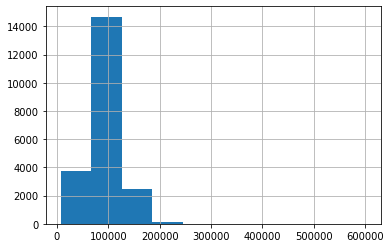

Распределение значений по post_year:


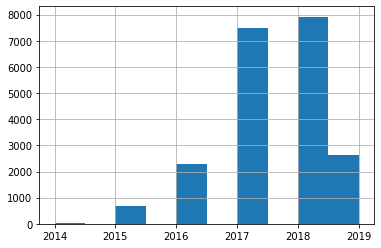

Распределение значений по post_month:


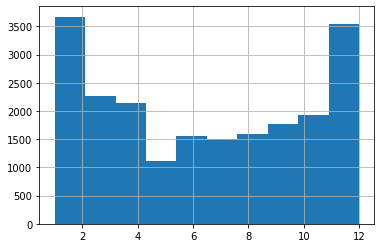

Распределение значений по post_day:


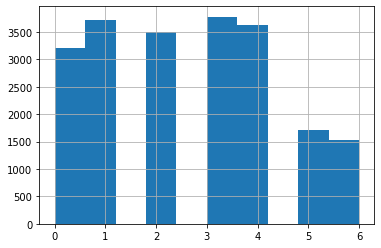

Распределение значений по floor_type:


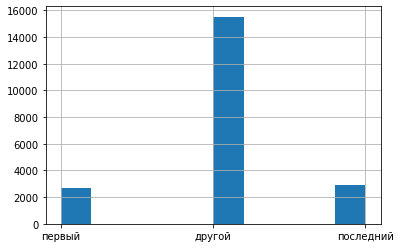

Распределение значений по cc_distance:


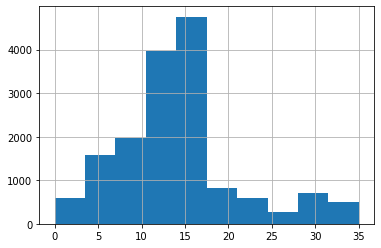

In [74]:
columns_to_check = ['sqm_price', 'post_year', 'post_month', 'post_day', 'floor_type', 'cc_distance']
for column in columns_to_check:
    print(f'Распределение значений по {column}:')
    data_fixed[column].hist()
    plt.show()

Выглядит хорошо. Идём дальше...

### Проведите исследовательский анализ данных

#### Изучение параметров объектов:

Анализируем данные по столбцу total_area:

count    21069.000000
mean        54.372029
std         20.246320
min         12.000000
25%         39.100000
50%         50.000000
75%         65.000000
max        146.000000
Name: total_area, dtype: object


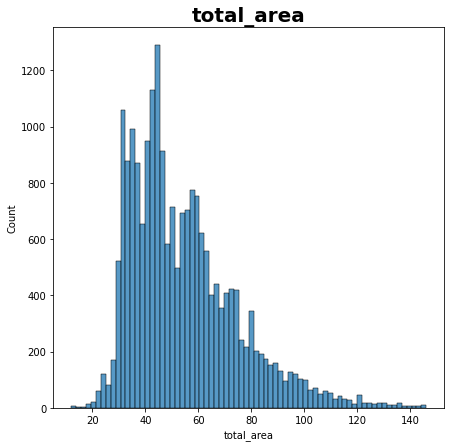

Анализируем данные по столбцу living_area:

count    19413.000000
mean        31.321335
std         14.276487
min          2.000000
25%         18.200000
50%         29.700000
75%         40.000000
max        107.000000
Name: living_area, dtype: object


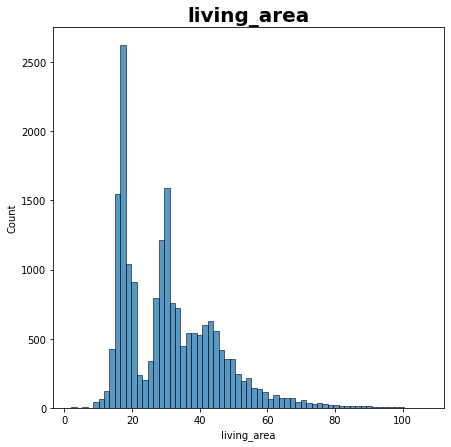

Анализируем данные по столбцу kitchen_area:

count    19041.000000
mean         9.601483
std          3.403765
min          1.300000
25%          7.000000
50%          9.000000
75%         11.000000
max         24.200000
Name: kitchen_area, dtype: object


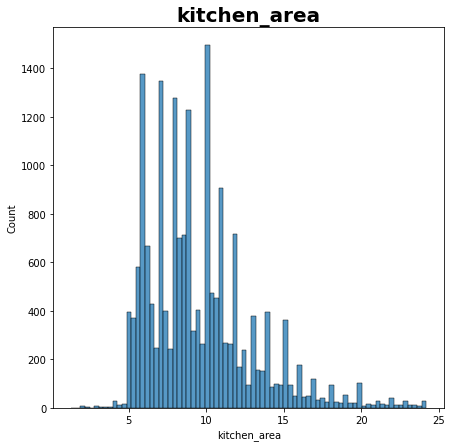

Анализируем данные по столбцу last_price:

count       21069.000000
mean      5116154.716171
std       2720899.447830
min        430000.000000
25%       3350000.000000
50%       4500000.000000
75%       6200000.000000
max      16913068.000000
Name: last_price, dtype: object


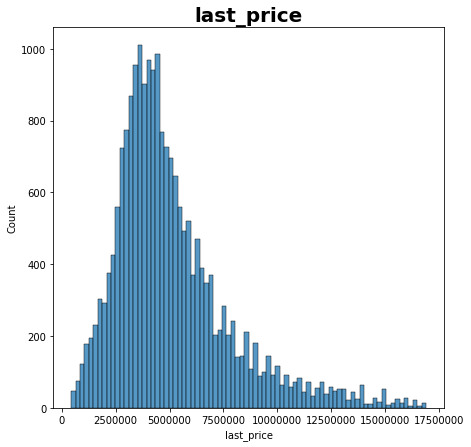

Анализируем данные по столбцу ceiling_height:

count    12805.000000
mean         2.702738
std          0.375447
min          1.000000
25%          2.500000
50%          2.600000
75%          2.760000
max         22.600000
Name: ceiling_height, dtype: object


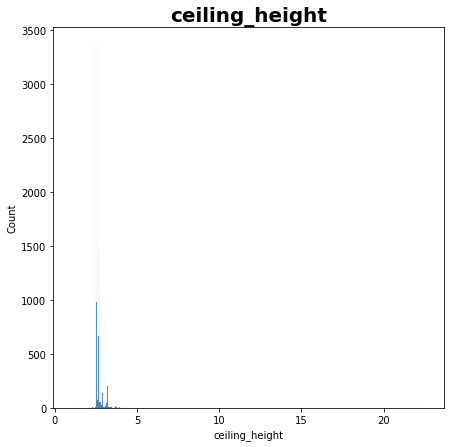

Анализируем данные по столбцу floor:

count    21069.000000
mean         5.932555
std          4.920476
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: object


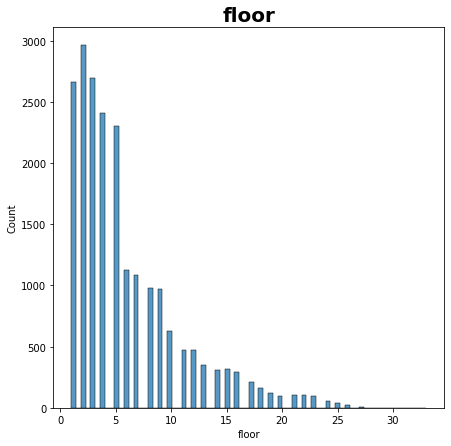

Анализируем данные по столбцу floors_total:

count    21069.000000
mean        10.866866
std          6.659878
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         52.000000
Name: floors_total, dtype: object


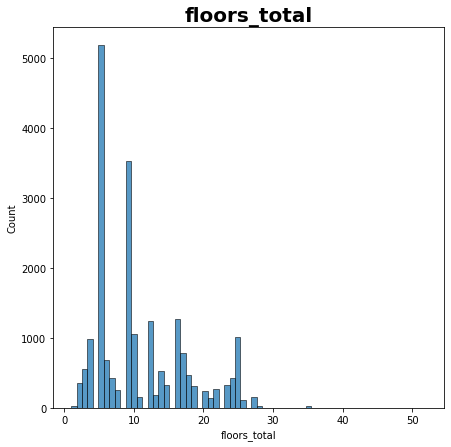

Анализируем данные по столбцу cityCenters_nearest:

count    15772.000000
mean     14045.433109
std       6998.007968
min        208.000000
25%      10255.000000
50%      13332.000000
75%      16276.250000
max      35475.000000
Name: cityCenters_nearest, dtype: object


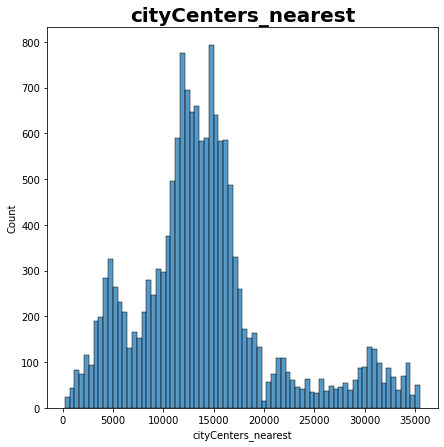

Анализируем данные по столбцу airports_nearest:

count    15756.000000
mean     28336.558581
std      12368.405817
min          0.000000
25%      17950.000000
50%      26585.000000
75%      36897.000000
max      61748.000000
Name: airports_nearest, dtype: object


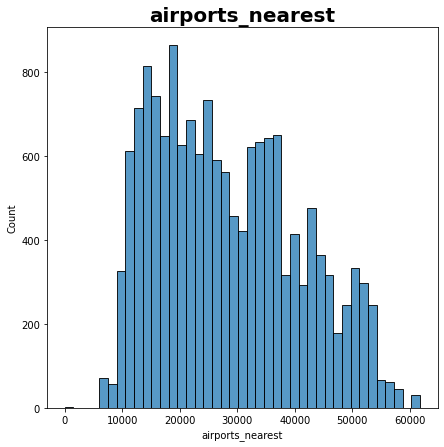

Анализируем данные по столбцу parks_nearest:

count    6652.000000
mean      464.262928
std       248.353955
min         1.000000
25%       289.750000
50%       455.000000
75%       608.000000
max      1568.000000
Name: parks_nearest, dtype: object


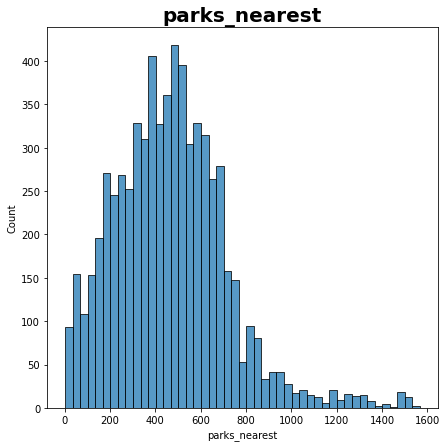

Анализируем данные по столбцу floor_type:

count      21069
unique         3
top       другой
freq       15525
Name: floor_type, dtype: object


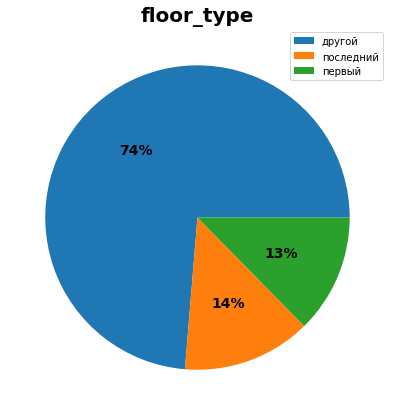

Анализируем данные по столбцу post_month:

count   21069.00
mean        6.41
std         3.49
min         1.00
25%         3.00
50%         6.00
75%        10.00
max        12.00
Name: post_month, dtype: float64


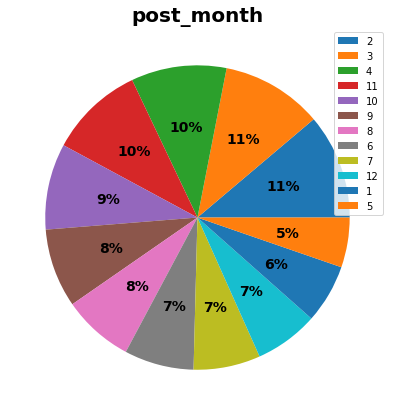

Анализируем данные по столбцу post_day:

count   21069.00
mean        2.57
std         1.79
min         0.00
25%         1.00
50%         3.00
75%         4.00
max         6.00
Name: post_day, dtype: float64


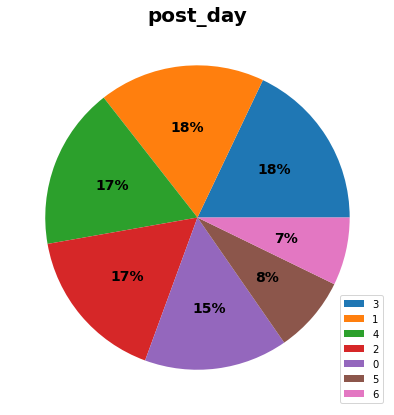

Анализируем данные по столбцу rooms:

count   21004.00
mean        1.97
std         0.92
min         1.00
25%         1.00
50%         2.00
75%         3.00
max         7.00
Name: rooms, dtype: float64


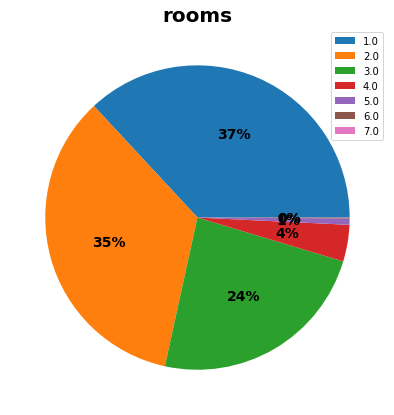

In [75]:
columns_to_analyse_numeric = ['total_area', 'living_area', 'kitchen_area', 'last_price',
                      'ceiling_height', 'floor', 'floors_total', 'cityCenters_nearest',
                     'airports_nearest', 'parks_nearest']

columns_to_analyse_types = ['floor_type', 'post_month', 'post_day', 'rooms']

for column in columns_to_analyse_numeric: #Для столбцов с числовыми значениями строим диаграммы:
    print(f'Анализируем данные по столбцу {column}:')
    print()
    print(data_fixed[column].describe().apply(lambda x: format(x, 'f'))) #Добавляем лямбда функцию для того, чтобы адекватно отобразить цену
    plt.figure(figsize=(7,7))
    plt.ticklabel_format(style='plain', axis='x') #Тоже самое для отображения на графике
    sns.histplot(data=data_fixed, x=column).set_title(column, weight='bold').set_fontsize('20')
    plt.show()
    
for column in columns_to_analyse_types: #Для столбцов с типами строим pie-чарты:
    print(f'Анализируем данные по столбцу {column}:')
    column_pie = data_fixed[column].value_counts()
    print()
    print(data_fixed[column].describe())
    plt.figure(figsize=(7,7))
    plt.pie(data=column_pie.index, x=column_pie, autopct='%.0f%%', textprops={'fontsize': 14, 'fontweight': 'bold'})
    plt.legend(column_pie.index, loc='best')
    plt.title(column, weight='bold').set_fontsize('20')
    plt.show()
    

In [76]:
#Отдельно хочется обратить внимание на показатели столбца `ceiling_height` - мы видим некоторое количество небольших значений
print("Top-5")
print(data_fixed['ceiling_height'].value_counts().sort_index().head(5))
print()

print("Bottom-5")
print(data_fixed['ceiling_height'].value_counts().sort_index().tail(5))
print()

print("Сколько в базе объектов с потолком ниже 2 метров?")
print(data_fixed.query('ceiling_height < 2')['ceiling_height'].count())
print()

print("Сколько в базе объектов с потолком выше 5 метров?")
print(data_fixed.query('ceiling_height > 5')['ceiling_height'].count())

Top-5
1.00     1
1.20     1
1.75     1
2.00    11
2.20     1
Name: ceiling_height, dtype: int64

Bottom-5
10.00    1
10.30    1
14.00    1
20.00    1
22.60    1
Name: ceiling_height, dtype: int64

Сколько в базе объектов с потолком ниже 2 метров?
3

Сколько в базе объектов с потолком выше 5 метров?
11


In [77]:
#Отдельно хочется посмотреть на размещение объектов по месяцам:
data_fixed['post_month'].value_counts().sort_index()

1     1317
2     2354
3     2266
4     2135
5     1115
6     1557
7     1496
8     1592
9     1765
10    1927
11    2120
12    1425
Name: post_month, dtype: int64

**Выводы по анализу базовых показателей параметров:**

- **Общая площадь** (`total_area`). Среднее значение площади объектов недвижимости, размещённых в базе - 54 квадратных метра, при этом 75% объектов имеют площадь меньше 65 квадратных метров. Большая часть объектов имеет площадь от 40 до 60 метров, при этом число очень маленьких и очень больших объектов значительно меньше.
- **Жилая площадь** (`living_area`). Среднее значение жилой площади в объектах базы составляет 31.3 квадратных метра, при этом наблюдается два пика - четверть объектов имеет площадь меньше 18.2 квадратных метров, значительная часть из них - как раз в районе этого значения. Второе "типичное" значение жилой площади - в районе 30 квадратных метров. Прочие варианты менее распространены, при этом лишь 25% объектов имеют жилую площадь больше, чем 40 квадратных метров.
- **Площадь кухни** (`kitchen_area`). Среднее значение площади кухни составляет 9 квадратных метров, при этом заметно множество "пиков" на графике, что говорит о наличии множества "типовых" размеров кухонь. При этом лишь незначительное число объектов имеет кухню размером менее 5 квадратных меров, и лишь 25% - кухню больше 11 квадратных метров.
- **Цена объекта** (`last_price`). Среднее значение цены объекта составляет в районе 5.1 миллионов рублей. При этом 75% объектов стоят меньше 6.2 миллионов. Распределение цены объектов ожидаемое - больше всего объектов находятся в пределах средней цены, незначительно число объектов - меньше неё (25% стоят менее 3.35 миллионов), при этом есть и "исключения", которые стоят гораздо больше (при этом стоит учитывать наличие в изначальной базе выбросов - которые стоят гораздо больше). Примечательно и достаточно большое значение стандартного отклонения - 2.7 миллионов, что говорит о наличии в базе недвижимости достаточно разного ценового уровня.
- **Количество комнат** (`rooms`). 37% представленных объектов имеют 1 комнату, ещё 35% - две комнаты, ещё 24% - три. Лишь оставшиеся 4% имеют 3 или более комнаты.
- **Высота потолков** (`ceiling_height`). Есть определённое количество недвижимости с очень низкими потолками (ниже 2 метров - таких 3), и с очень высоким (выше 5 метров - таких 11). При этом средний потолок в базе получился высотой 2.7 метра, и практически все объекты имеют такую стандартную высоту.
- **Этаж квартиры** (`floor`). 75% объектов в базе находятся на 8 этаже или ниже, половина - на четвёртом или ниже. Среднее значение при этом составляет в районе 6.
- **Тип этажа квартиры** (`floor_type`). Примерно 13% объектов, представленных в базе находятся на 1 этаже, 14% - на последнем. Остальные 74% (получилось больше 100% из-за округления) - на прочих этажах.
- **Общее количество этажей в доме** (`floors_total`). В объектах нашей базы средняя "этажность" составляет 9 этажей, при этом в половине число этажей здания составляет меньше 9, в 75% - меньше 16. На графике чётко видны два пика - много домов имеют в районе 5 этажей, и много - в районе 10.
- **Расстояние до центра города в метрах** (`cityCenters_nearest`). Среднее расстояние от объекта до центра города - 14 километров, при этом 75% объектов находятся в 16 километрах или ближе. Большая часть объектов "сосредоточена" на таком расстоянии - однако есть и значимая группа находящихся примерно в 5 километрах.
- **Расстояние до ближайшего аэропорта** (`airports_nearest`). В случае с расстоянием до ближайшего аэропорта всё несколько по другому - среднее расстояние составляет 28 километров, однако в целом достаточно много объектов находятся в пределах 55 километров, а распределение нельзя отнести к нормальному - пиков достаточно много.
- **Расстояние до ближайшего парка** (`parks_nearest`). Среднее расстояние до ближайшего парка у объектов в базе - 460 метров, при этом 75% находятся в 600 метрах или ближе, а подавляющее большинство находятся ближе 850 метров.
- **День публикации объявления** (`post_day`). В целом, объявления чаще размещают в рабочие дни. В субботу и в воскресенье объекты размещают примерно в два раза реже, чем в остальные дни.
- **Месяц публикации объявления** (`post_month`). Здесь трудно сказать о какой-то закономерности - в целом заметно, что меньше всего объявлений размещали в январе и мае, больше всего - в феврале, марте и апреле, а также в октябре.

#### Теперь посмотрим на скорость продажи квартир:

In [78]:
print(f'Среднее значение срока продажи квартиры в базе - {data_fixed["days_exposition"].mean()}')
print(f'Медианное значение срока продажи квартиры в базе - {data_fixed["days_exposition"].median()}')
data_fixed['days_exposition'].describe()

Среднее значение срока продажи квартиры в базе - 148.30670229590444
Медианное значение срока продажи квартиры в базе - 89.00000000000001


count   18337.00
mean      148.31
std       155.69
min         1.00
25%        43.00
50%        89.00
75%       201.00
max       747.00
Name: days_exposition, dtype: float64

<AxesSubplot:>

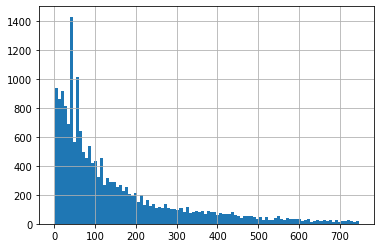

In [79]:
data_fixed['days_exposition'].hist(bins=100)

Анализируя эти сведения можно сделать вывод о том, что **в среднем** квартиры продаются примерно за 148 дней, половина объектов продаётся за 89 дней или меньше.

Если ориентироваться на квартили - то можно судить о том, что **"быстрой"** можно считать продажу объекта за 43 дня или менее (1 квартиль), **"умеренной"** - продажу за 201 день или менее (3 квартиль), и **"долгой"** - продажу объекта за больше чем 201 дней.

In [80]:
#Давайте исследуем моду показателя `days_exposition`
data_fixed['days_exposition'].mode()

0   45.00
dtype: float64

In [81]:
data_fixed['days_exposition'].value_counts().head(10)

45.00    858
60.00    524
7.00     223
30.00    198
4.00     170
3.00     149
90.00    146
5.00     143
14.00    140
20.00    135
Name: days_exposition, dtype: int64

Можем сделать вывод о том, что большая часть участников отталкивается от имеющихся ограничений, завязанный на условиях размещения (нет желания переплачивать за дополнительную публикацию). В связи с этим мы наблюдаем "пики" на значениях, соответствующих срокам публикации объявлений согласно условиям "Яндекс-недвижимости".

#### Оценим влияние различных факторов на общую стоимость объекта

In [82]:
#Обозначим столбцы, влияние которых нам интересно и разобьём их по группам для строительства разных графиков
#в зависимости от того, какой показатель будет нагляднее демонстрировать разницу цен

columns_of_interest_scatter = ['total_area', 'living_area', 'kitchen_area']

columns_of_interes_bar = ['floor_type'] #Да, здесь список из одного. Сделано для наглядности и возможного добавления новых.

columns_of_interest_line = ['rooms', 'post_year', 'post_month', 'post_day']

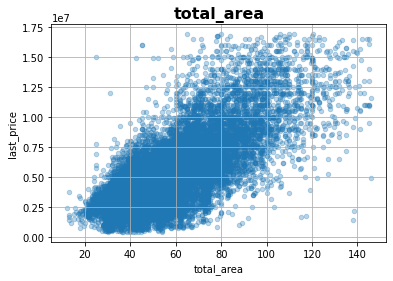

Корреляция total_area с ценой составляет: 0.7420784595713078


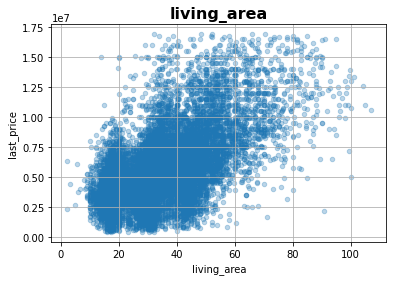

Корреляция living_area с ценой составляет: 0.634744916347212


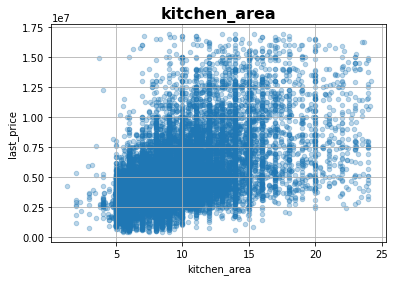

Корреляция kitchen_area с ценой составляет: 0.5255501473648309


In [83]:
#Нарисуем scatter_plot-ы для столбцов первой категории:
for column in columns_of_interest_scatter:
    data_fixed.plot(x=column, y='last_price', kind='scatter', grid=True, alpha=0.3)
    plt.title(column, weight='bold').set_fontsize('16')
    plt.show()
    print(f'Корреляция {column} с ценой составляет: {data_fixed[column].corr(data_fixed["last_price"])}')

            last_price  percentage_of_overall
floor_type                                   
другой      4650000.00                   1.03
первый      3850000.00                   0.86
последний   4100000.00                   0.91


<AxesSubplot:title={'center':'Связь типа этажа с ценой'}, xlabel='floor_type'>

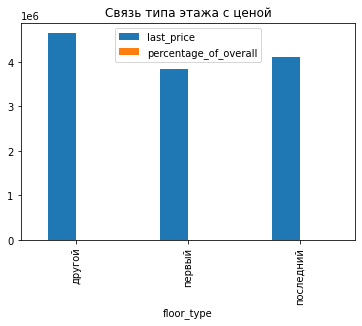

In [84]:
#Оценим как связан тип этажа с ценой:

floor_info = data_fixed.pivot_table(index='floor_type', values='last_price', aggfunc='median')
floor_info['percentage_of_overall'] = floor_info['last_price'] / data_fixed['last_price'].median()
print(floor_info)
floor_info.plot(kind='bar', title="Связь типа этажа с ценой")

Показатель корреляции параметра rooms = 0.4734032827053704


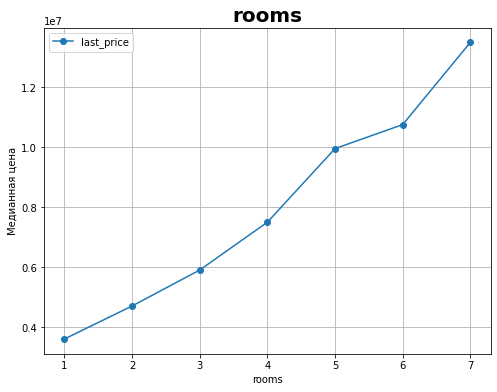

Показатель корреляции параметра post_year = 0.006843321526031929


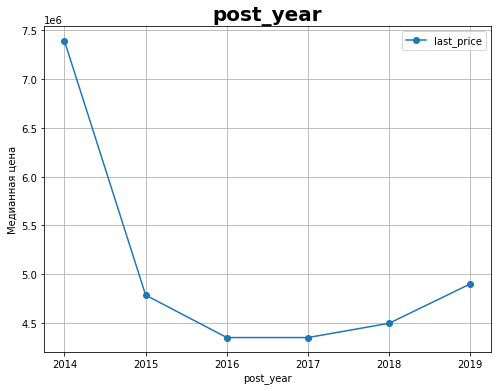

Показатель корреляции параметра post_month = 0.0024305385787781577


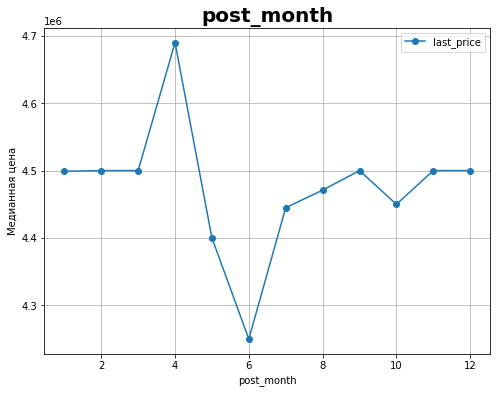

Показатель корреляции параметра post_day = -0.01056656116788915


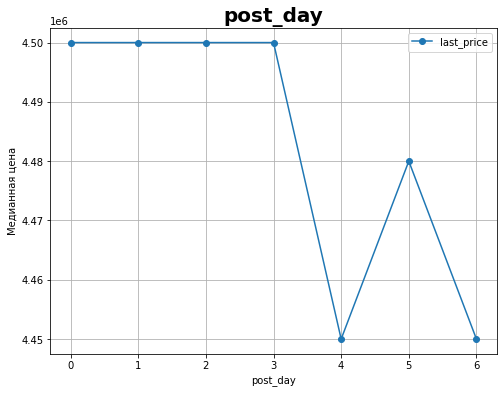

In [85]:
#Как обстоят дела с последним показателем?
for column in columns_of_interest_line:
    corr_coeff = data_fixed[column].corr(data_fixed["last_price"])
    print(f'Показатель корреляции параметра {column} = {corr_coeff}')
    column_data = data_fixed.pivot_table(index=column, values='last_price', aggfunc='median')
    column_data.plot(style='o-',
                    figsize=(8,6),
                    xlabel=column,
                    ylabel='Медианная цена',
                    grid=True)
    plt.title(column, weight='bold').set_fontsize('20')
    plt.show()

In [86]:
corr = data_fixed.corr() #получаем таблицу корреляций
corr.style.background_gradient(cmap='coolwarm') #Окрасим, чтобы было понятно, куда смотреть:

Таким образом, можем сделать следующие выводы по тестируемым показателям:

- **Общая площадь** (`total_area`). Этот показатель демонстрирует прямую зависимость и положительную корреляцию равную 0.74, что позволяет говорить о сильной прямой зависимости - чем больше объём квартиры, тем выше цена.
- **Жилая площадь** (`living_area`). Этот показатель также демонстрирует аналогичную динамику, однако положительная корреляция в этом случае равняется 0.63, что говорит о несколько меньшей зависимости цены квартиры от жилой площади, чем от общей.
- **Площадь кухни** (`kitchen_area`). Аналогично - показатель корреляции равный 0.52 позволяет говорить о прямой положительной зависимости, однако из трёх тестируемых показателей площадь кухни влияет меньше остальных.
- **Количество комнат** (`rooms`). Показатель демонстрирует прямую зависимость и неплохую корреляцию - 0.47, что соответствует логике "чем больше комнат - тем дороже квартира"
- **Тип этажа** (`floor_type`). Анализ показал, что первый и последний этажи стоят несколько дешевле медианного значения - первый примерно на 14.5%, последний - примерно на 9%.
- **Дата размещения** (`post_year`, `post_month`, `post_day`). 
    - Средняя стоимость недвижимости сильно менялась в зависимости от **года** - как видно на графике, самые высокие цены были в 2014 году, в 2015 году мы наблюдали сильный спад, который несколько замедлился к 2014, а после 2014 цены снова стали расти вверх. 
    - Зависимость **месяца** в целом заметна - объекты, размещённые в апреле заметно дороже, а в мае/июне - дешевле. После июня наблюдается некое "восстановление", однако июль всё ещё дешевле медианного значения, что позволяет судить об определённой "сезонности" цены.
    - Заметна связь **дня** публикации с ценой - объявления, размещаемые до пятницы как правило имеют большую цену, в то время как пятничные и "выходные" объекты - меньшую.



#### Цена одного квадратного метра...

In [87]:
data_fixed.columns

Index(['last_price', 'total_area', 'living_area', 'kitchen_area',
       'airports_nearest', 'cityCenters_nearest', 'parks_nearest',
       'ponds_nearest', 'days_exposition', 'total_images',
       'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total',
       'floor', 'is_apartment', 'studio', 'open_plan', 'balcony',
       'locality_name', 'parks_around3000', 'ponds_around3000',
       'locality_proper', 'sqm_price', 'post_year', 'post_month', 'post_day',
       'floor_type', 'cc_distance'],
      dtype='object')

In [88]:
#Отберём топ-10 населённых пунктов по числу объявлений:
data_top10 = (
    data_fixed.pivot_table(index='locality_proper', values='sqm_price', aggfunc=['mean', 'count'])
    .sort_values(by=[('count', 'sqm_price')], ascending=False)
    .head(10)
    .sort_values(by=[('mean', 'sqm_price')], ascending=False)
)

#Рассчитаем для них цену квадратного метра:
data_top10

mean     count
                sqm_price sqm_price
locality_proper                    
санкт-петербург 107548.15     13815
пушкин          101239.69       332
кудрово          95530.05       447
парголово        90185.68       320
мурино           86185.90       567
шушары           78513.57       429
колпино          75222.24       322
гатчина          68724.78       290
всеволожск       67123.33       378
выборг           58052.97       222

Как мы видим, **наиболее дорогим из анализируемых нами населённых пунктов оказался Санкт-Петербург**, со средней стоимостью одного квадратного метра равной 107.5 тысячам рублей. **Самый "дешёвый" квадратный метр из населённых пунктов "топ-десятки" в Выборге** - около 58 тысяч.

#### Цена за километр в Санкт-Петербурге

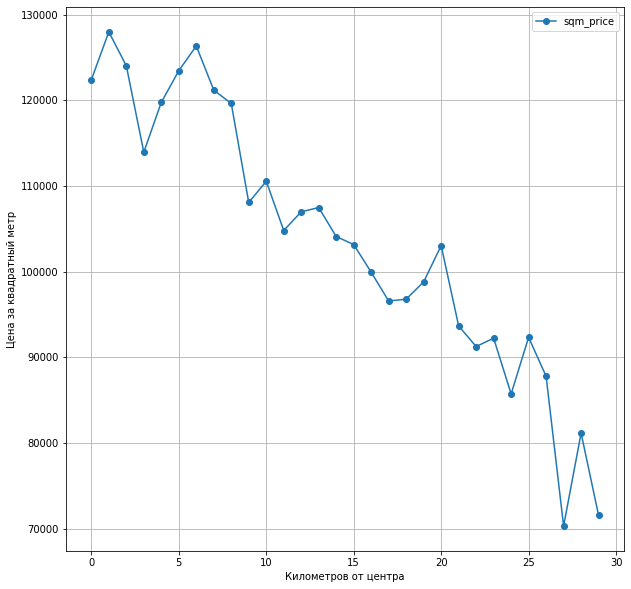

In [89]:
data_spb = data_fixed.query('locality_proper == "санкт-петербург"')

rub_per_km = (data_spb.pivot_table(index='cc_distance', values='sqm_price', aggfunc='mean')
              .plot(style='o-',
                   figsize=(10,10),
                   xlabel='Километров от центра',
                   ylabel='Цена за квадратный метр',
                   grid=True)
)

**Явной является связь этих двух показателей.** Общий тренд ожидаем - **вместе с ростом расстояние от центра падает цена за квадратный метр**. При этом, время от времени наблюдаются определённые колебания (например, в 20 километрах - возможно, на этом расстоянии находится какая-то элитная недвижимость?), однако в целом тренд очевиден.

### Общий вывод

- **Предобработка данных:**
    - **Пропуски:** Учитывая, что база данных - это база объявлений, которые заполняют владельцы недвижимости, то **наиболее вероятная причина появления пропусков в данных - банальное незаполнение тех или иных ячеек владельцами объектов недвижимости.** В случае картографических данных (расстояние до ближайших центров городов, аэропортов, парков и прудов) можно предположить наличие у рассчитывающей программы какого-то лимита (пишем, если расстояние меньше 100 км)
    - **Тип данных:** В нескольких колонках необходимо было изменить тип данных. Колонка с датой регистрации была записана в формате "string", что логично и меняется достаточно просто через `pd.to_datetime`. Ещё ряд колонок имел изменённые значения из-за пропусков, которые там были (`is_apartment` вместо булева типа стал `object`, ещё ряд - из `int` стал `float`. В одном случае изменить не удалось - т.к. в столбце `floors_total` сохранились пропуски, то заменить его на `int` невозможно. Информация об этом взята из FAQ по pandas: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html
    - **Выбросы**. В нескольких столбцах были выбросы-ошибки, которые можно было исправить. После этого статистическим путём было отброшено ещё ~2000 наблюдений, выходящих за рамки трёх межквартильных размахов, что позволило повысить точность данных.\
    Такое решение было принято на основании задач исследования - нам необходимо **понять общие закономерности,** которые наблюдаются в данных, а не исследовать выбросы отдельно (анализ выбросов - отдельная тема. К примеру, можно было бы изучить, что объединяет объекты, которые очень долго не могли сдать/продать и т.п., но это за рамками задач текущего проекта)
    - **Добавление новых столбцов**. Столбцы были добавлены исходя из расчётов на основании данных, имеющихся в других столбцах.
    - **Выводы по анализу базовых показателей параметров:** указаны выше (подробный разбор)
    - **Выводы по влиянию факторов на цену** - прямую зависимость и значительный показатель корреляции продемонстрировали показатели общей, жилой и кухонной площади квартиры, а также числа комнат - чем эти показатели больше, тем больше и цена квартиры. Также можно говорить о влиянии года - заметно падение цен после пика 2014 вплоть до 2016, после чего возобновился рост. Также присутствует определённая "сезонность" - дороже других апрельские объекты, а вот после него - в мае-июле наблюдается спад цен. Интересно также и влияния дня - объекты, размещаемые в пятницу или на выходных как правило стоят несколько дешевле.
    -**Цены по населённым пунктам** - ожидаемо, при анализе цен за квадратным метр в 10 самых часто встречающихся в базе данных населённых пунктах самым дорогим оказался Санкт-Петербург (107.5 тысяч рубелй за квадратный метр). Самым дешёвым же оказался Выборг - примерно 58 тысяч рублей.
    -**Расстояние от центра** - в целом подтвердилась базовая гипотеза о том, что с ростом расстояния от центра стоимость квадратного метра недвижимости падает. Однако, есть и интересный кейс - на расстоянии в 25 километров мы наблюдаем очередной пик цен, а на расстоянии свыше примерно 32 и вовсе начинается рост. Предположение - на этом расстоянии начинаются коттеджные посёлки и прочая элитная недвижимость, которая снова начинает расти в цене.

**Чек-лист готовности проекта**

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод